# Sample diverse nucleoside structures using implicit solvent MD and torsion scan

- Cluster multiple implicit MD using pseudo sugar parameters  
- Run torsion scan against chi dihedral angle with RDKit

In [1]:
import os, sys, math
import numpy as np
import glob
import copy
import mdtraj
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, FormatStrFormatter, AutoMinorLocator
import seaborn as sns
import barnaba as bb

In [2]:
# plot settings
pd.options.display.max_rows = None
pd.options.display.max_columns = None
pd.options.display.precision = 1
pd.options.display.float_format = '{:.1f}'.format

params = {'legend.fontsize': 40, 
          'font.size': 40, 
          'axes.labelsize': 48,
          'axes.titlesize': 48,
          'xtick.labelsize': 40,
          'ytick.labelsize': 40,
          'savefig.dpi': 600, 
          'figure.figsize': [32, 8],
          'xtick.major.size': 10,
          'xtick.minor.size': 7,
          'ytick.major.size': 10,
          'ytick.minor.size': 7}

plt.rcParams.update(params)

In [3]:
def radian_to_degree(a):    
    a[np.where(a<0.0)] += 2.*np.pi
    a *= 180.0/np.pi
    return a

In [39]:
def plot_backbone_chi(angle):
    # histogram
    angle = radian_to_degree(angle)
    fig = plt.figure()
    ax = fig.add_subplot(1,1,1)
    ax.hist(angle, bins=60)
    plt.show()
    plt.close()
            
    # trajectory
    fig = plt.figure()
    ax = fig.add_subplot(1,1,1)
    ax.plot(angle)
    ax.set_ylim(0,360)
    plt.show()
    plt.close

In [40]:
def plot_sugar_pucker(pucker):
    fig = plt.figure(figsize=(12,8))
    ax = fig.add_subplot(1,1,1,polar=True)
    ax.scatter(pucker[0], pucker[1], s=10)

    p3 = np.pi/5
    ax.text(0.5*p3, 1.6, "C3'-endo", ha='center', fontsize=16, fontweight='bold')
    ax.text(1.3*p3, 1.5, "C4'-exo",  ha='center', fontsize=16)
    ax.text(2.5*p3, 1.5, "O4'-endo", ha='center', fontsize=16)
    ax.text(3.7*p3, 1.5, "C1'-exo",  ha='center', fontsize=16)
    ax.text(4.5*p3, 1.6, "C2'-endo", ha='center', fontsize=16, fontweight='bold')
    ax.text(5.5*p3, 1.5, "C3'-exo",  ha='center', fontsize=16)
    ax.text(6.5*p3, 1.5, "C4'-endo", ha='center', fontsize=16)
    ax.text(7.5*p3, 1.6, "O4'-exo",  ha='center', fontsize=16)
    ax.text(8.5*p3, 1.5, "C1'-endo", ha='center', fontsize=16)
    ax.text(9.5*p3, 1.5, "C2'-exo",  ha='center', fontsize=16)

    xt = np.arange(0, 2*np.pi, p3)
    ax.set_xticks(xt)
    ax.set_yticks([])
    ax.set_ylim(0, 1.2)
    ax.tick_params(axis='both', labelsize=12)
    plt.tight_layout()

    plt.show()
    #plt.savefig("pucker.png")    
    plt.close()

In [41]:
def cluster(feat, n_clusters):
    from sklearn.cluster import KMeans
    from scipy.spatial.distance import euclidean

    kmeans = KMeans(n_clusters=n_clusters, random_state=0, n_init="auto").fit(feat)

    # Loop over all clusters and find index of closest point to the cluster center.
    frame_idx = []
    for idx in range(kmeans.n_clusters):
        # get all points assigned to each cluster
        cluster_feat = feat[kmeans.labels_ == idx]
        # get all indices of points assigned to this cluster
        cluster_idx = np.where(kmeans.labels_ == idx)[0]

        cluster_center = kmeans.cluster_centers_[idx]
        min_idx = np.argmin([euclidean(feat[_idx], cluster_center) for _idx in cluster_idx])

        frame_idx.append(cluster_idx[min_idx])

        #print('cluster center ', cluster_cen)
        #print('closest point to cluster center: ', cluster_feat[min_idx])
        #print('closest index of point to cluster center: ', cluster_idx[min_idx])
        #print('  ', feat[cluster_pts_indices[min_idx]])
        
    return frame_idx

In [42]:
def run(files, n_clusters):
    name = files[0].split('/')[2].split('.')[0]
    traj = mdtraj.load(files, top=f'../md/crd/{name}.pdb')

    # backbone chi
    chi, _ = bb.backbone_angles_traj(traj, angles=['chi'])
    chi = chi.reshape(chi.shape[0], 1)
    angle = copy.deepcopy(chi)
    plot_backbone_chi(angle)

    # sugar pucker
    pucker, _ = bb.pucker_rao_traj(traj)
    pucker = pucker.reshape(pucker.shape[0], pucker.shape[2]).T
    plot_sugar_pucker(pucker)

    # cluster
    #feat = np.concatenate((chi, pucker.T), axis=1)
    feat = pucker.T
    frame_idx = cluster(feat, n_clusters)

    # save
    traj[frame_idx].save_netcdf(f'traj_cls_{name}.nc')

    # check cluster sample
    angle = copy.deepcopy(chi)
    plot_backbone_chi(angle[frame_idx])
    plot_sugar_pucker(pucker[:,frame_idx])

## 1. Cluster trajectory

Perform Kmeans clustering using sugar pucker pseudoangle information (phase and amplitude) to get diverse sugar pucker structures.

In [43]:
n_clusters = 100

#### adenosine

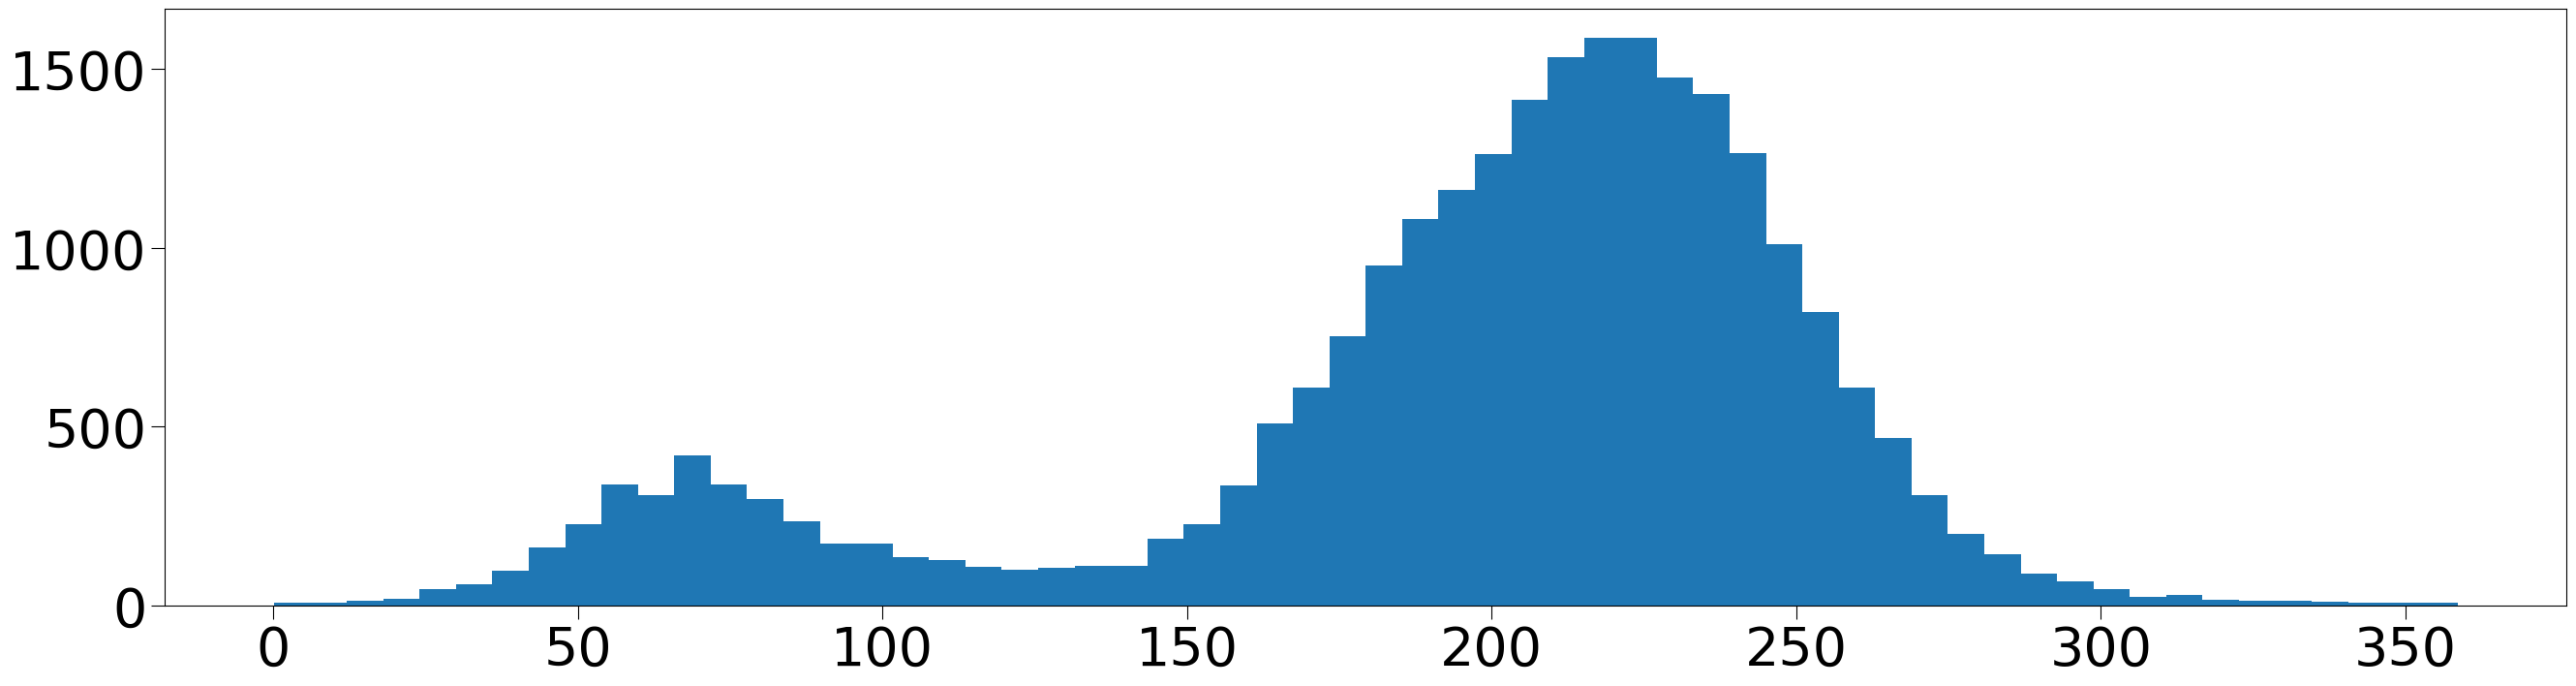

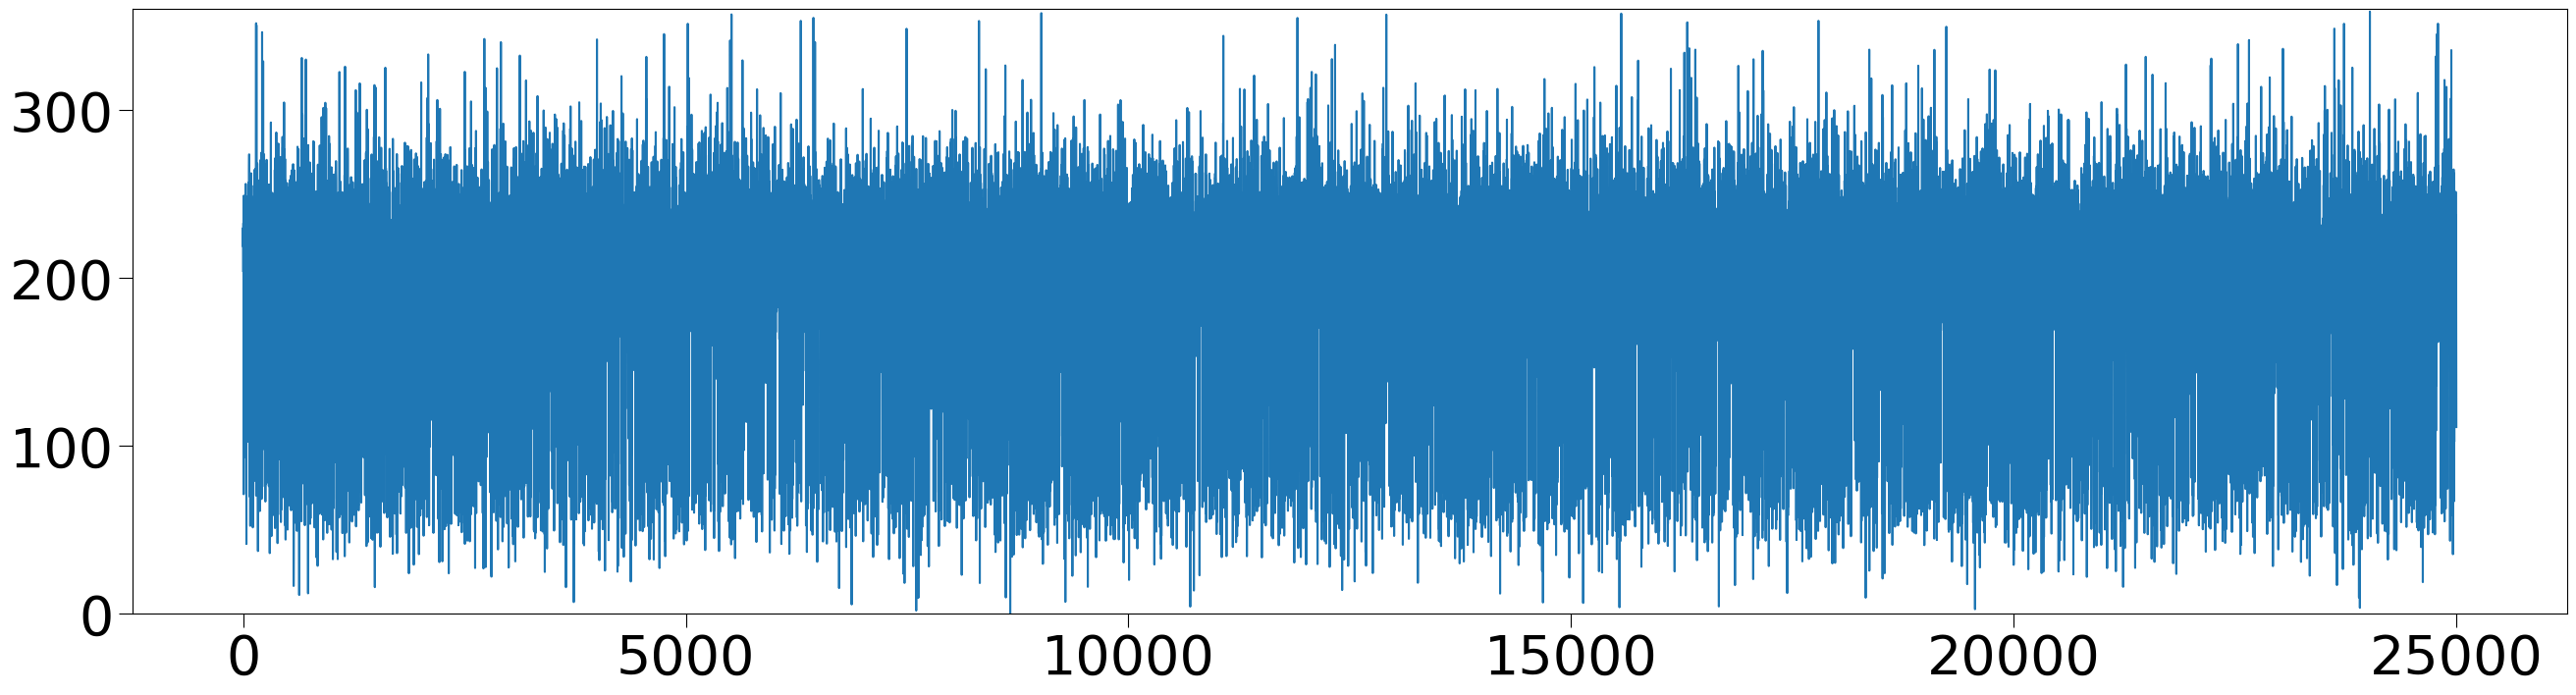

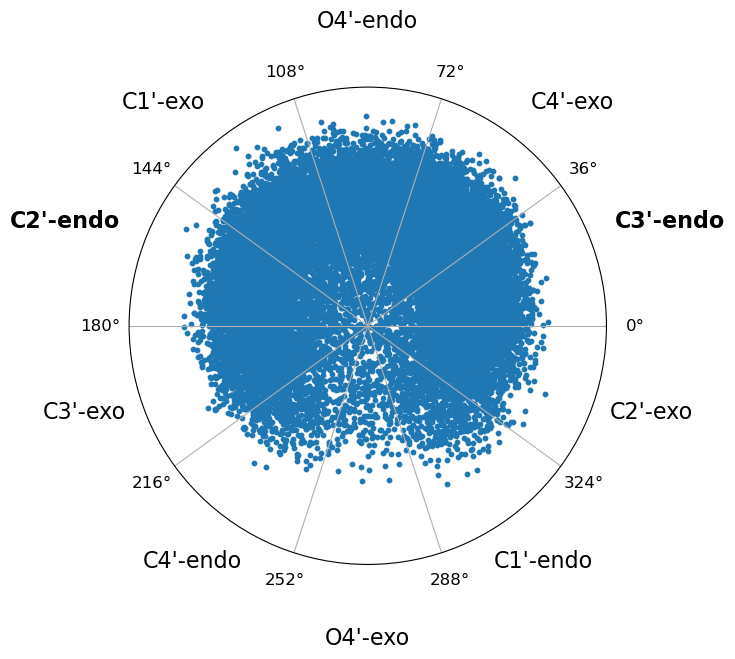

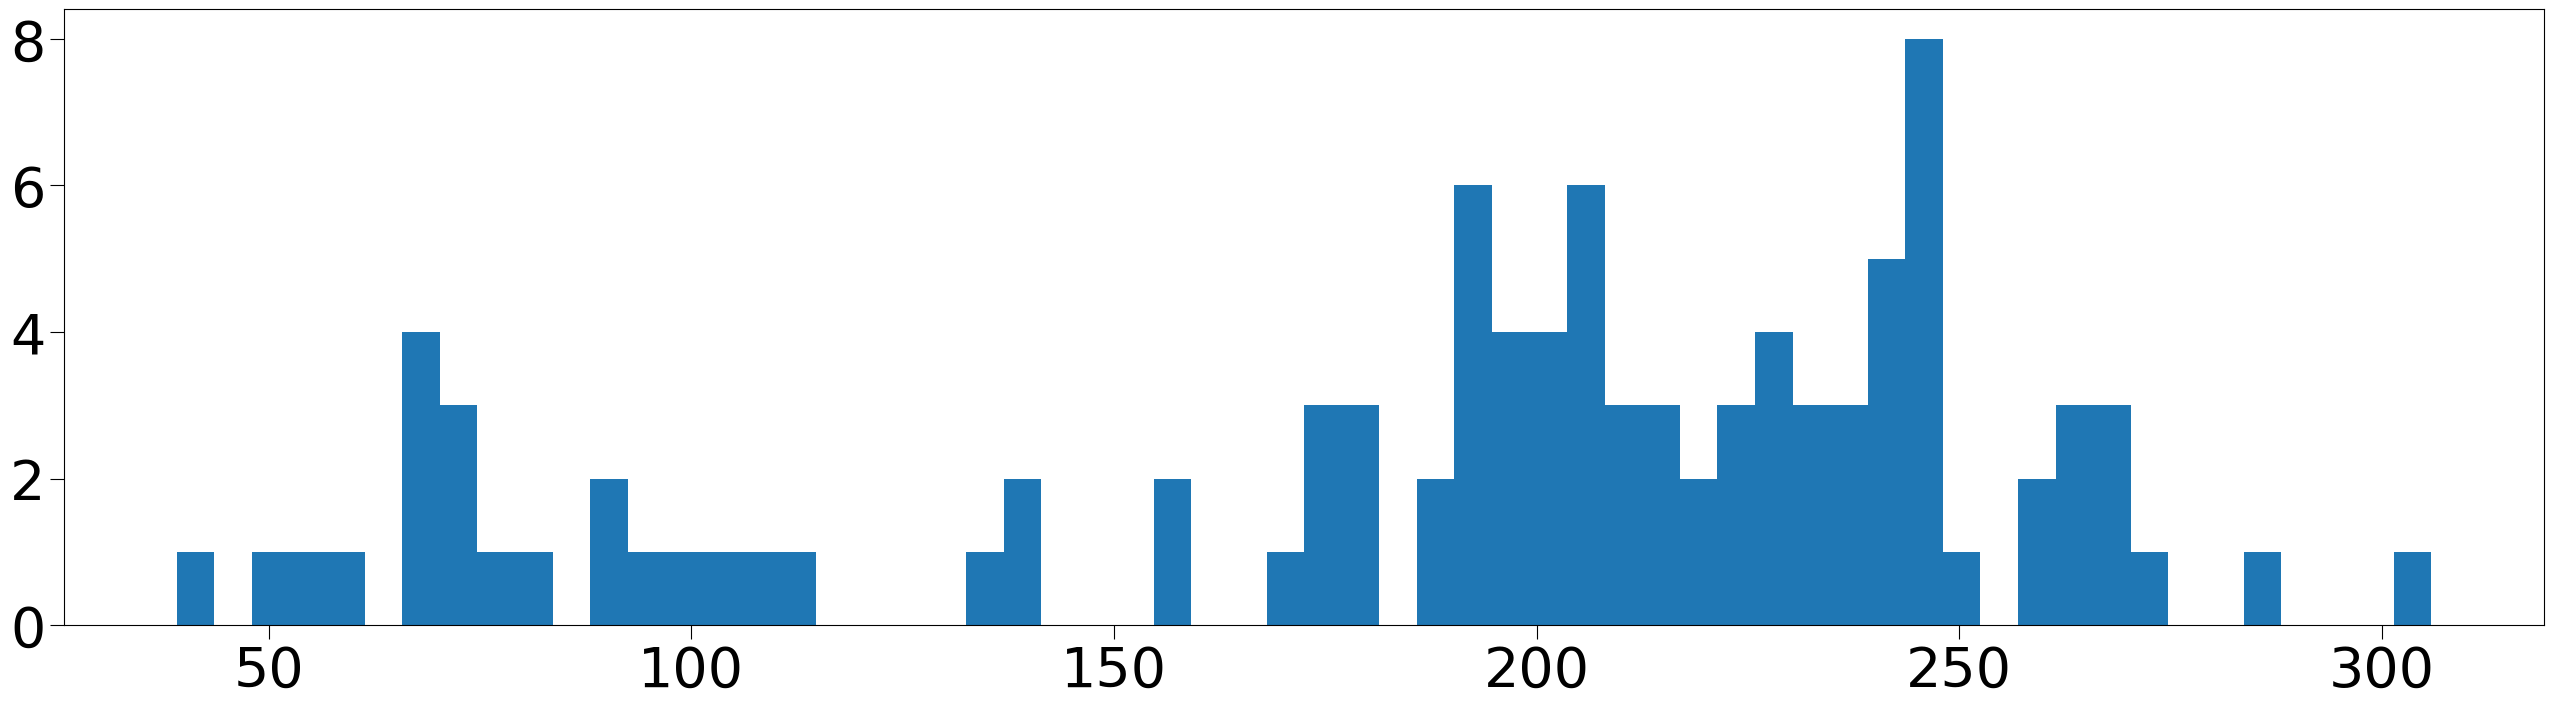

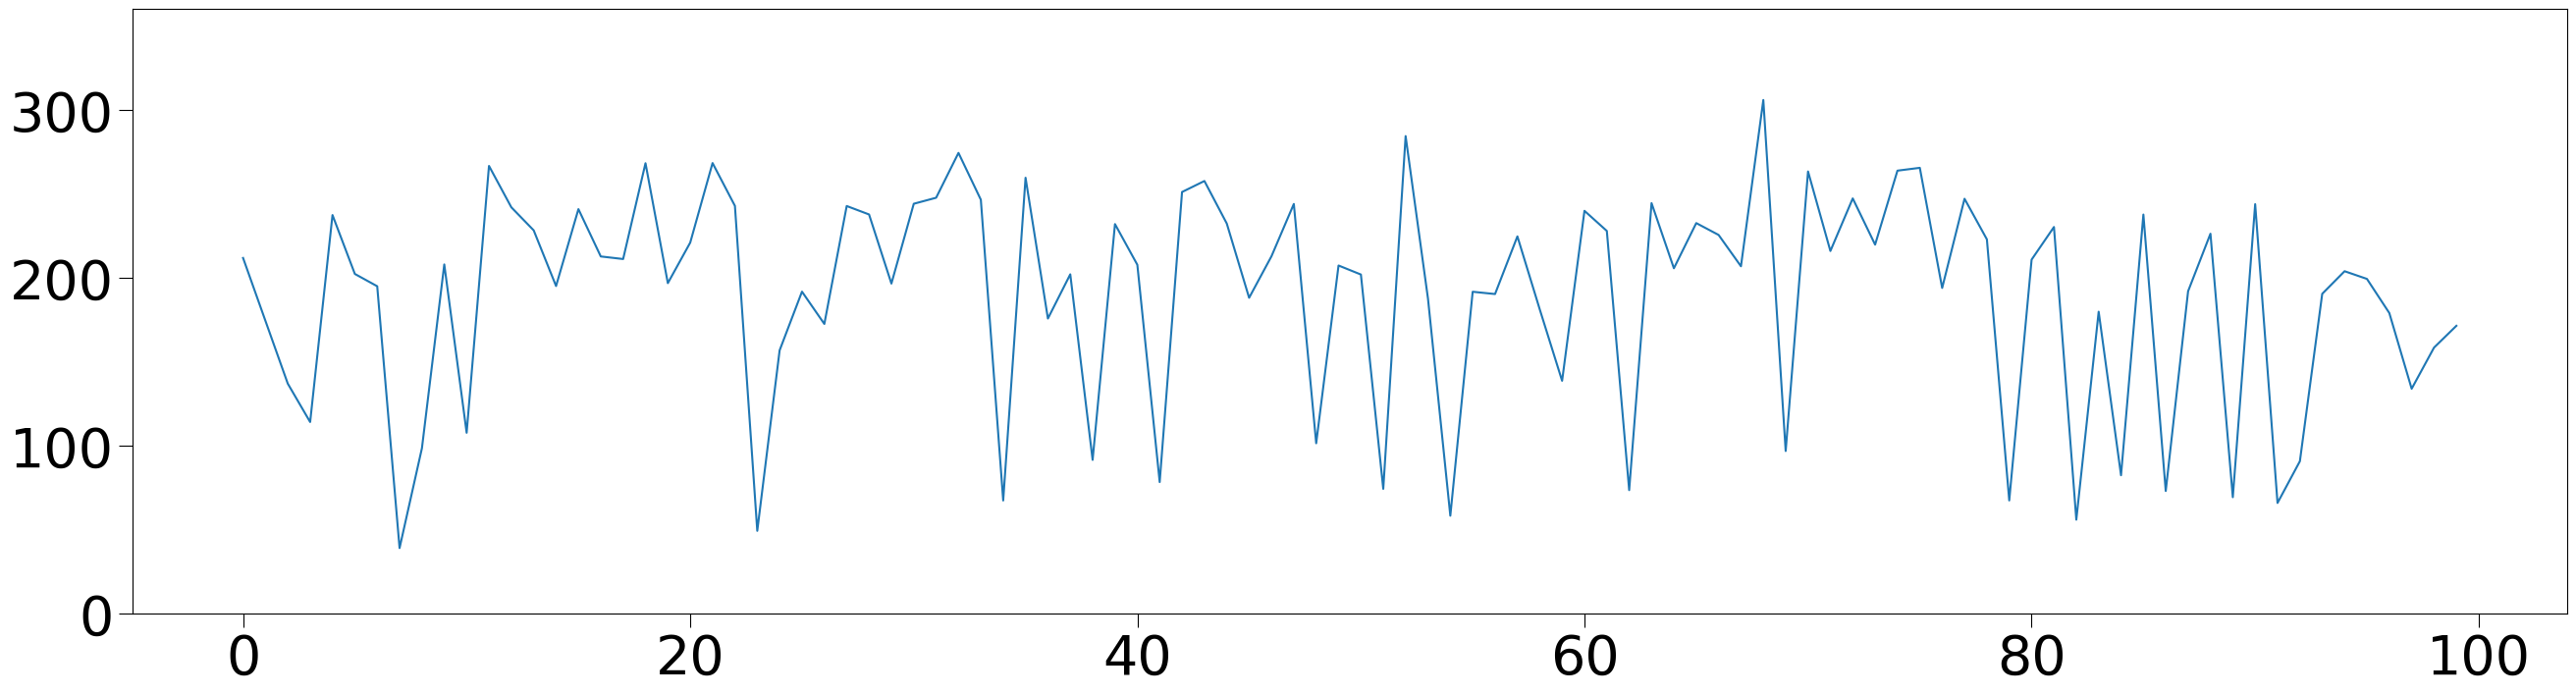

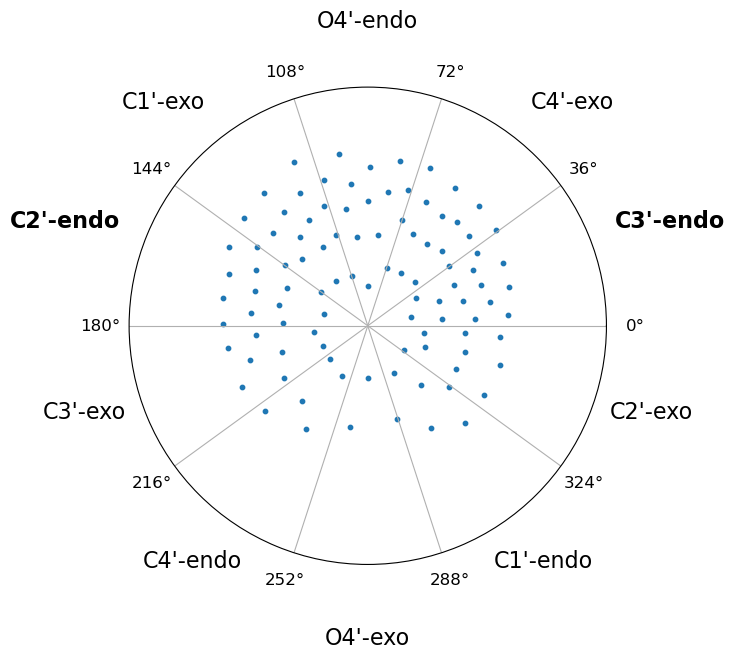

In [44]:
files = glob.glob("../md/a*/traj.nc")
run(files, n_clusters)

#### cytidine

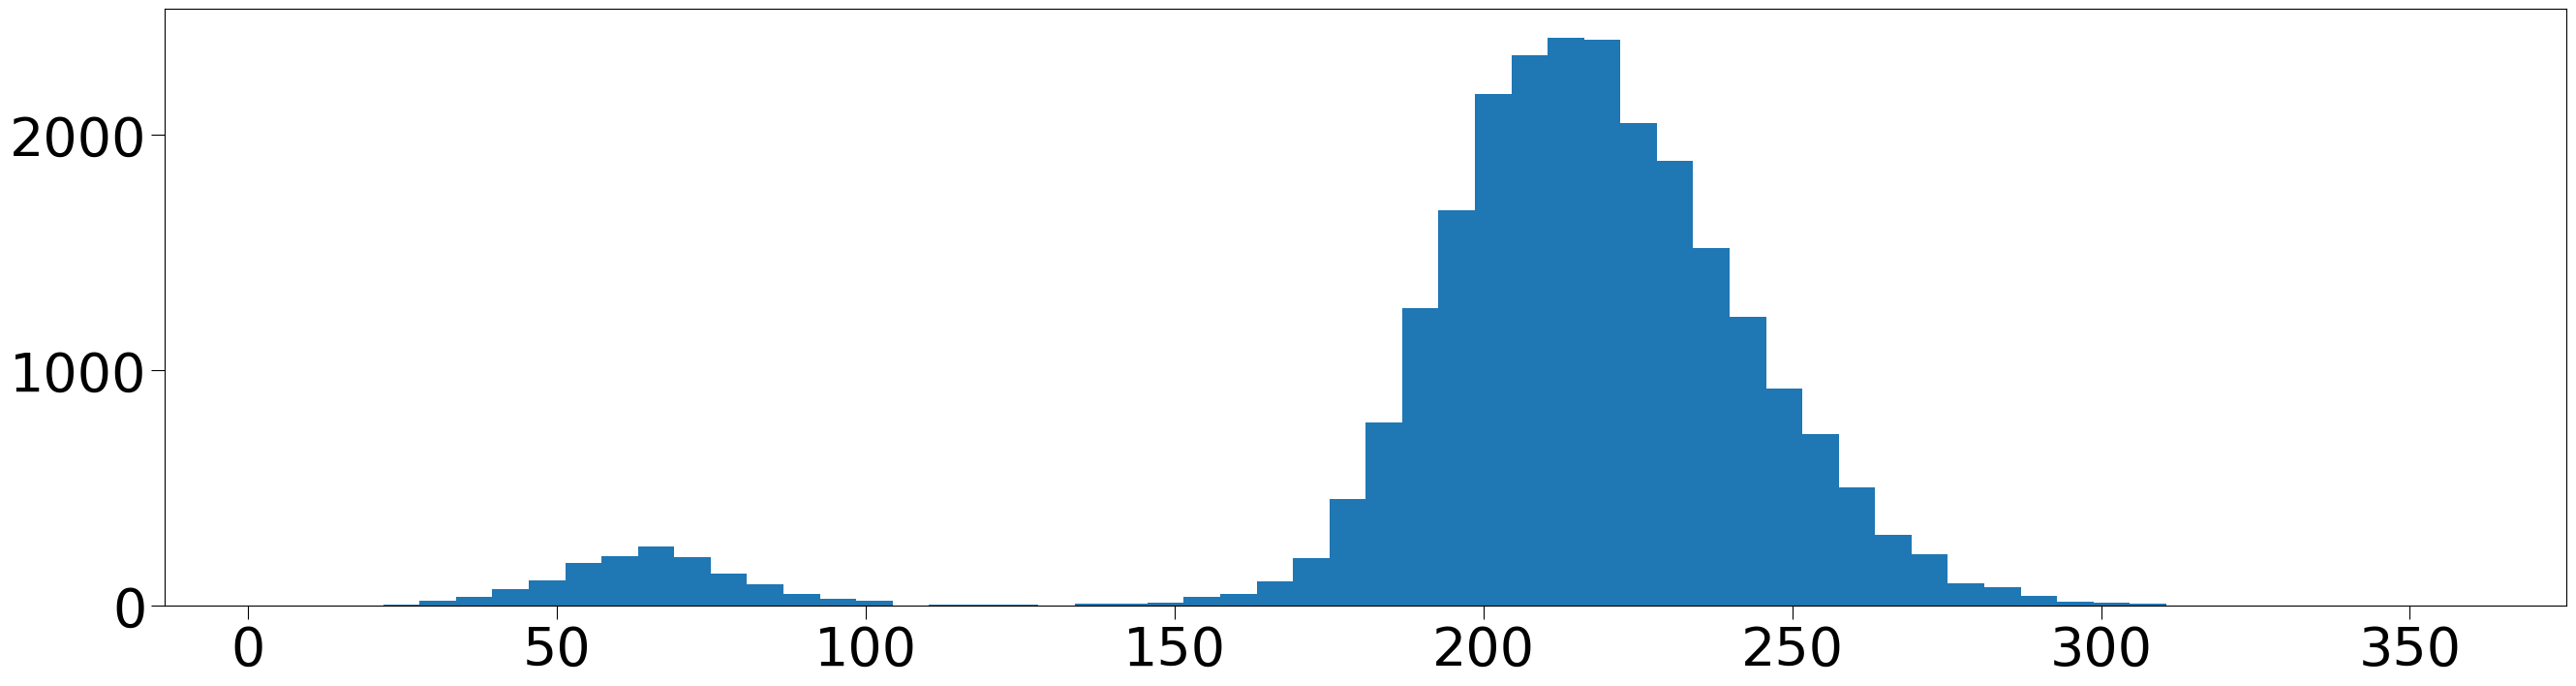

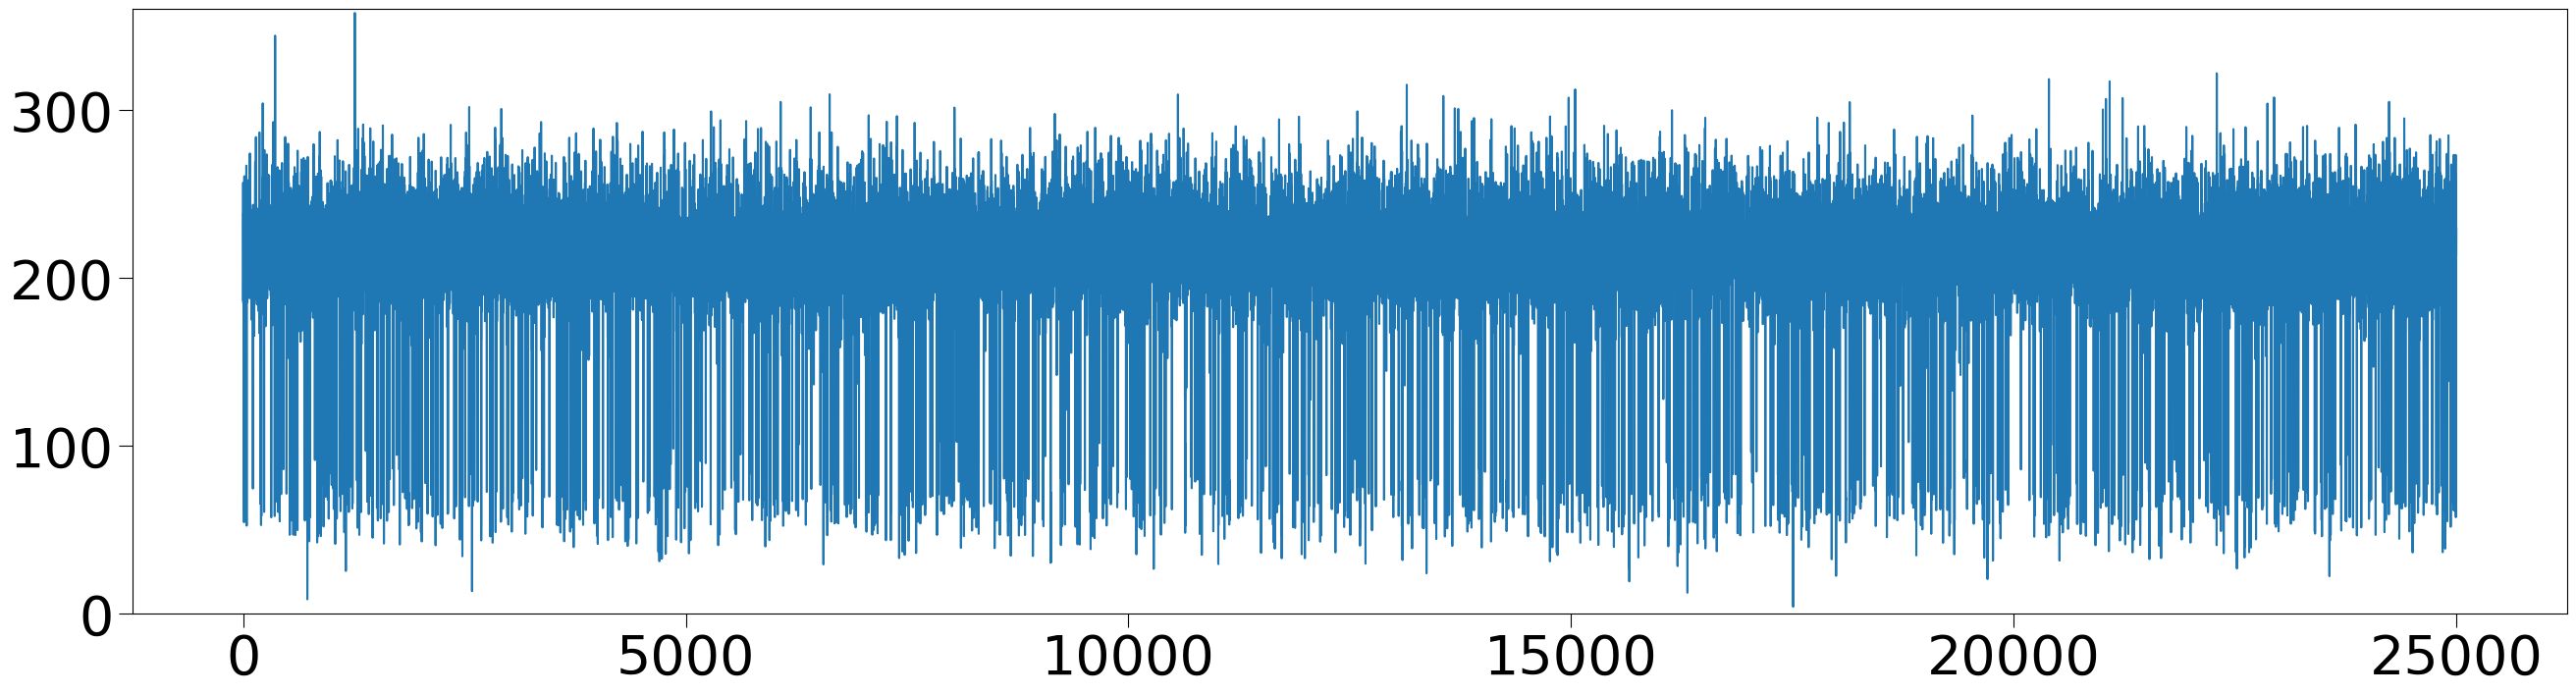

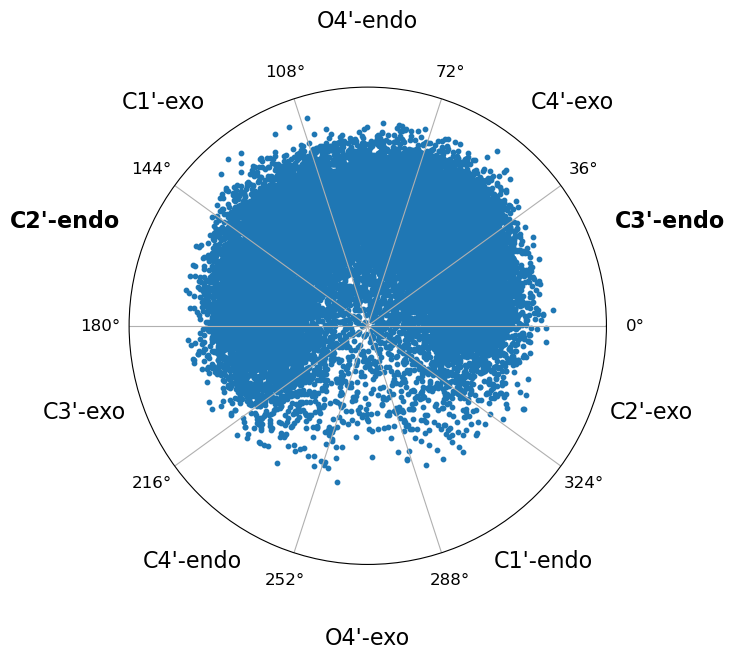

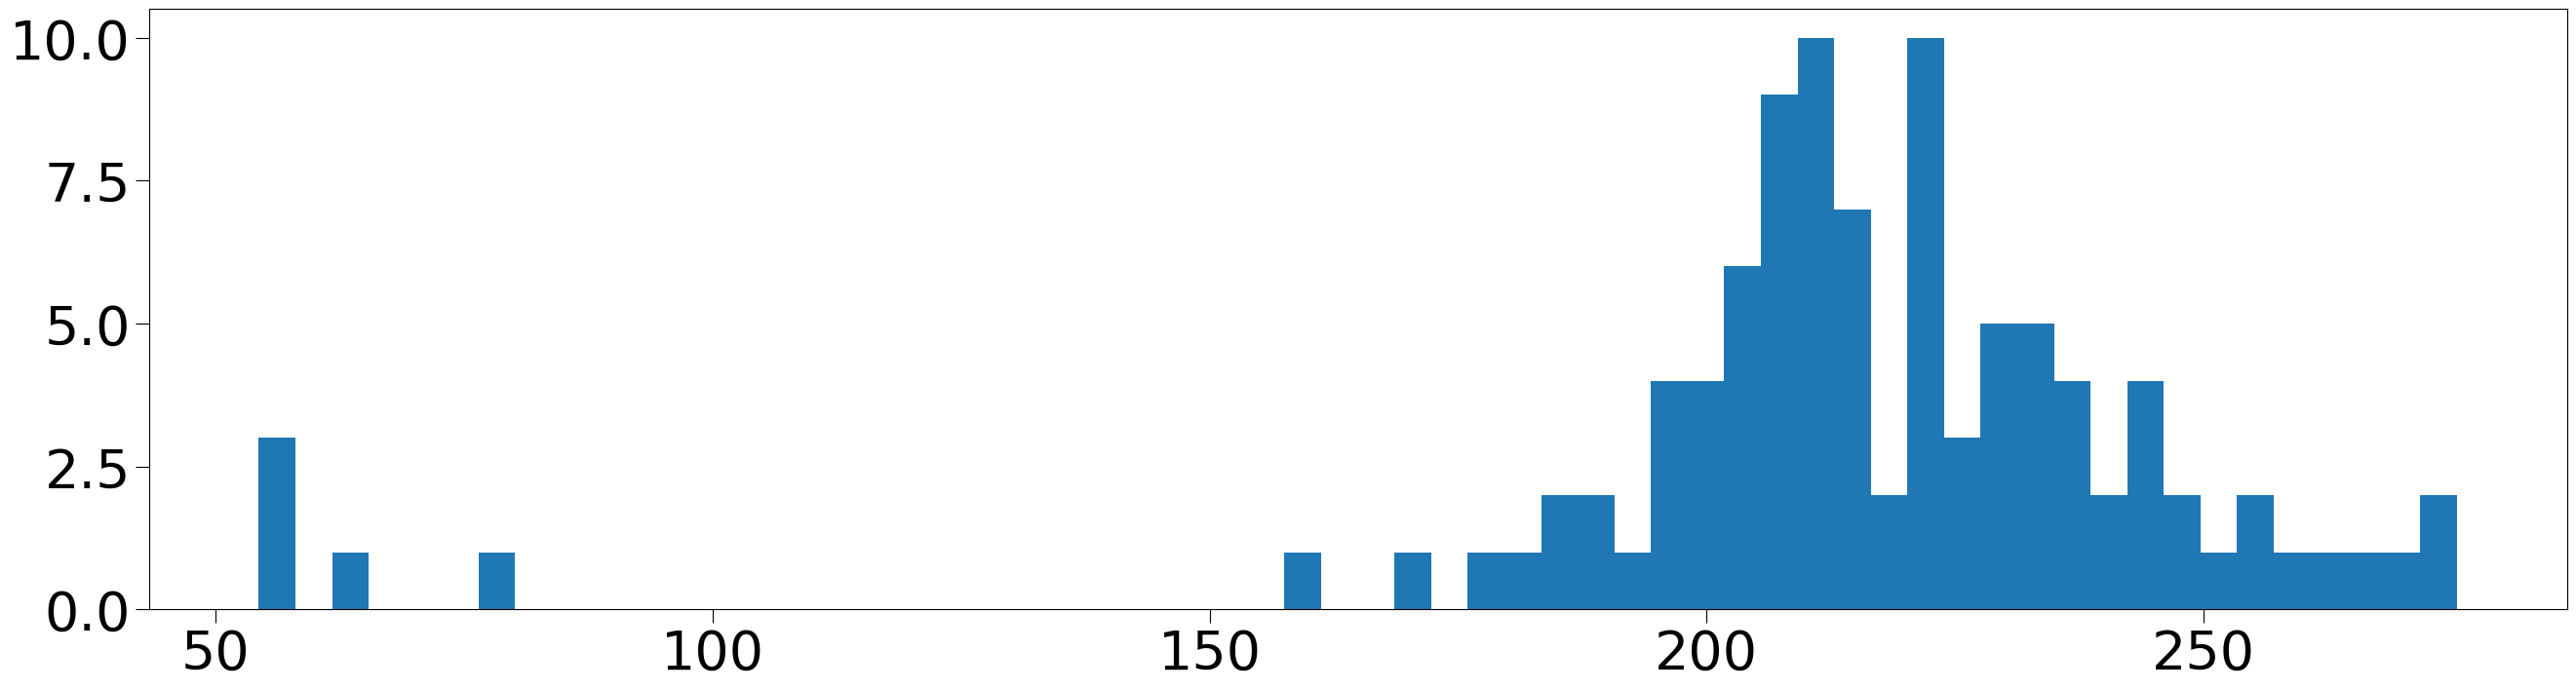

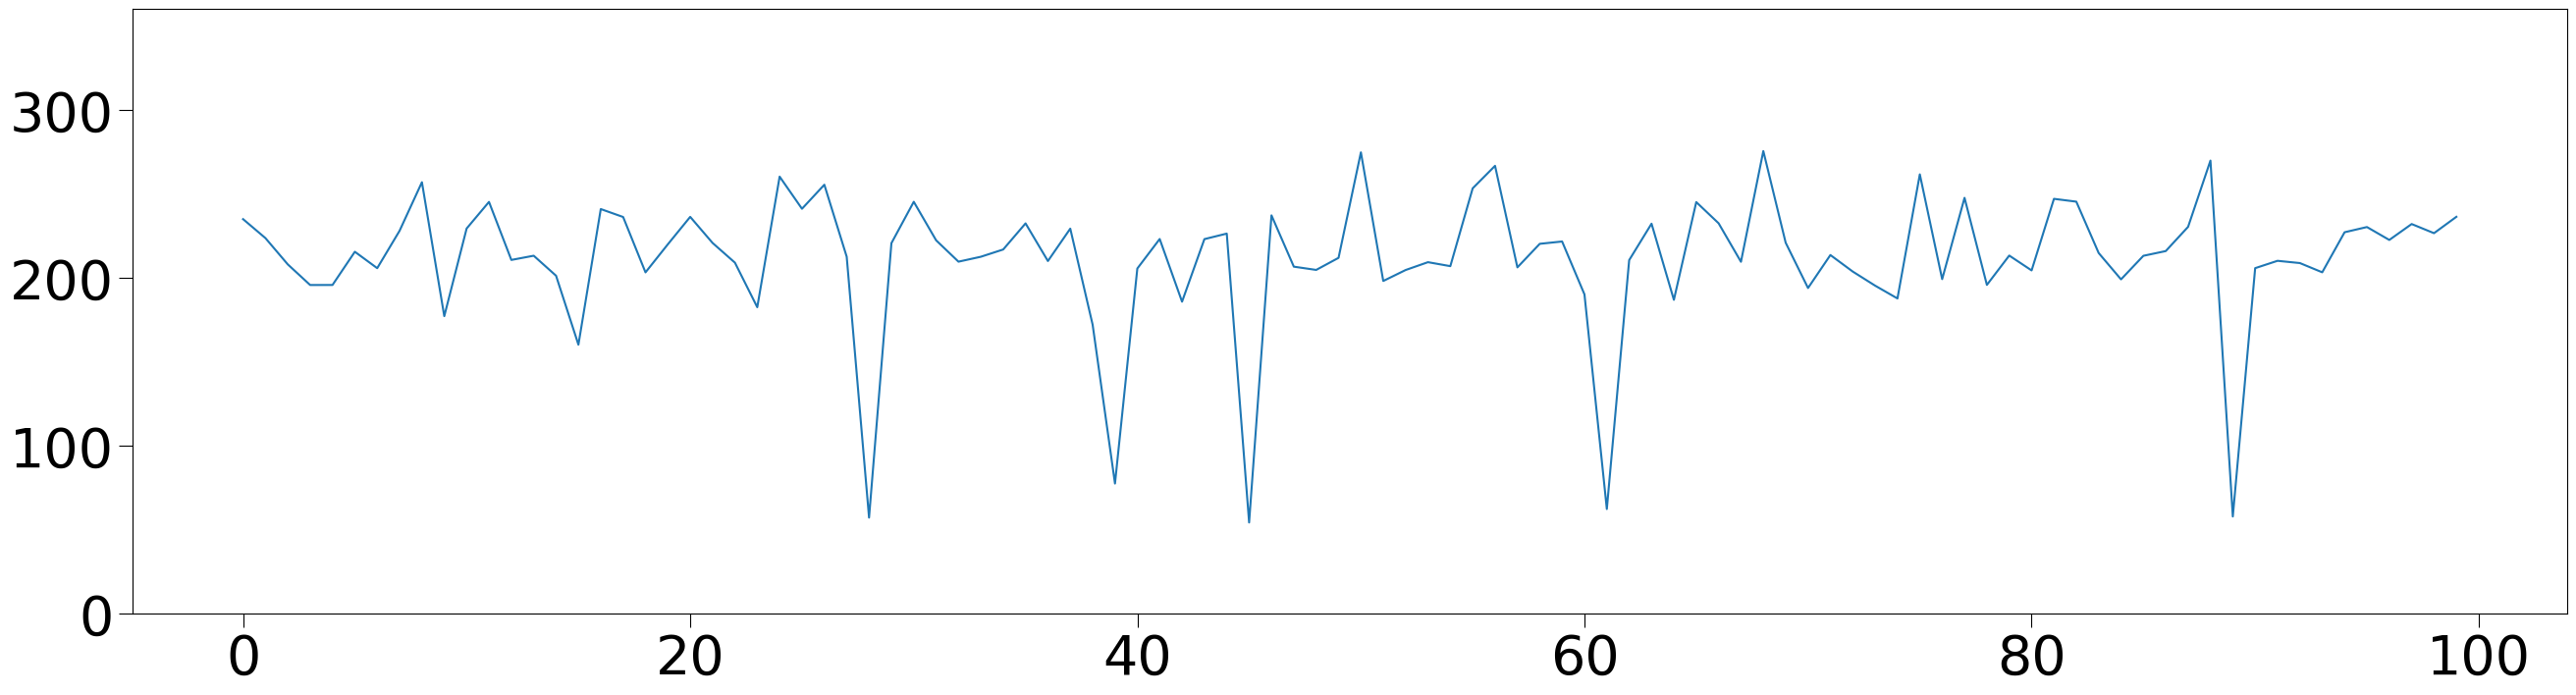

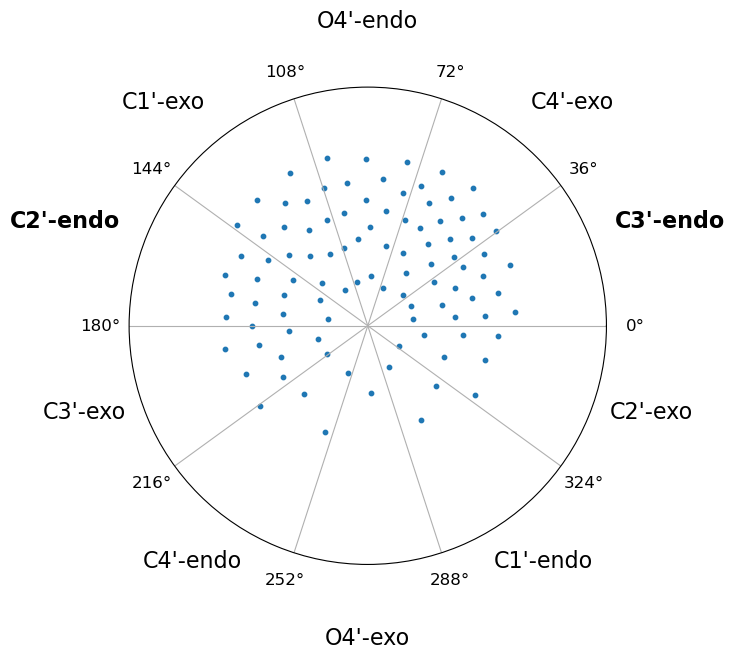

In [45]:
files = glob.glob("../md/c*/traj.nc")
run(files, n_clusters)

#### guanosine

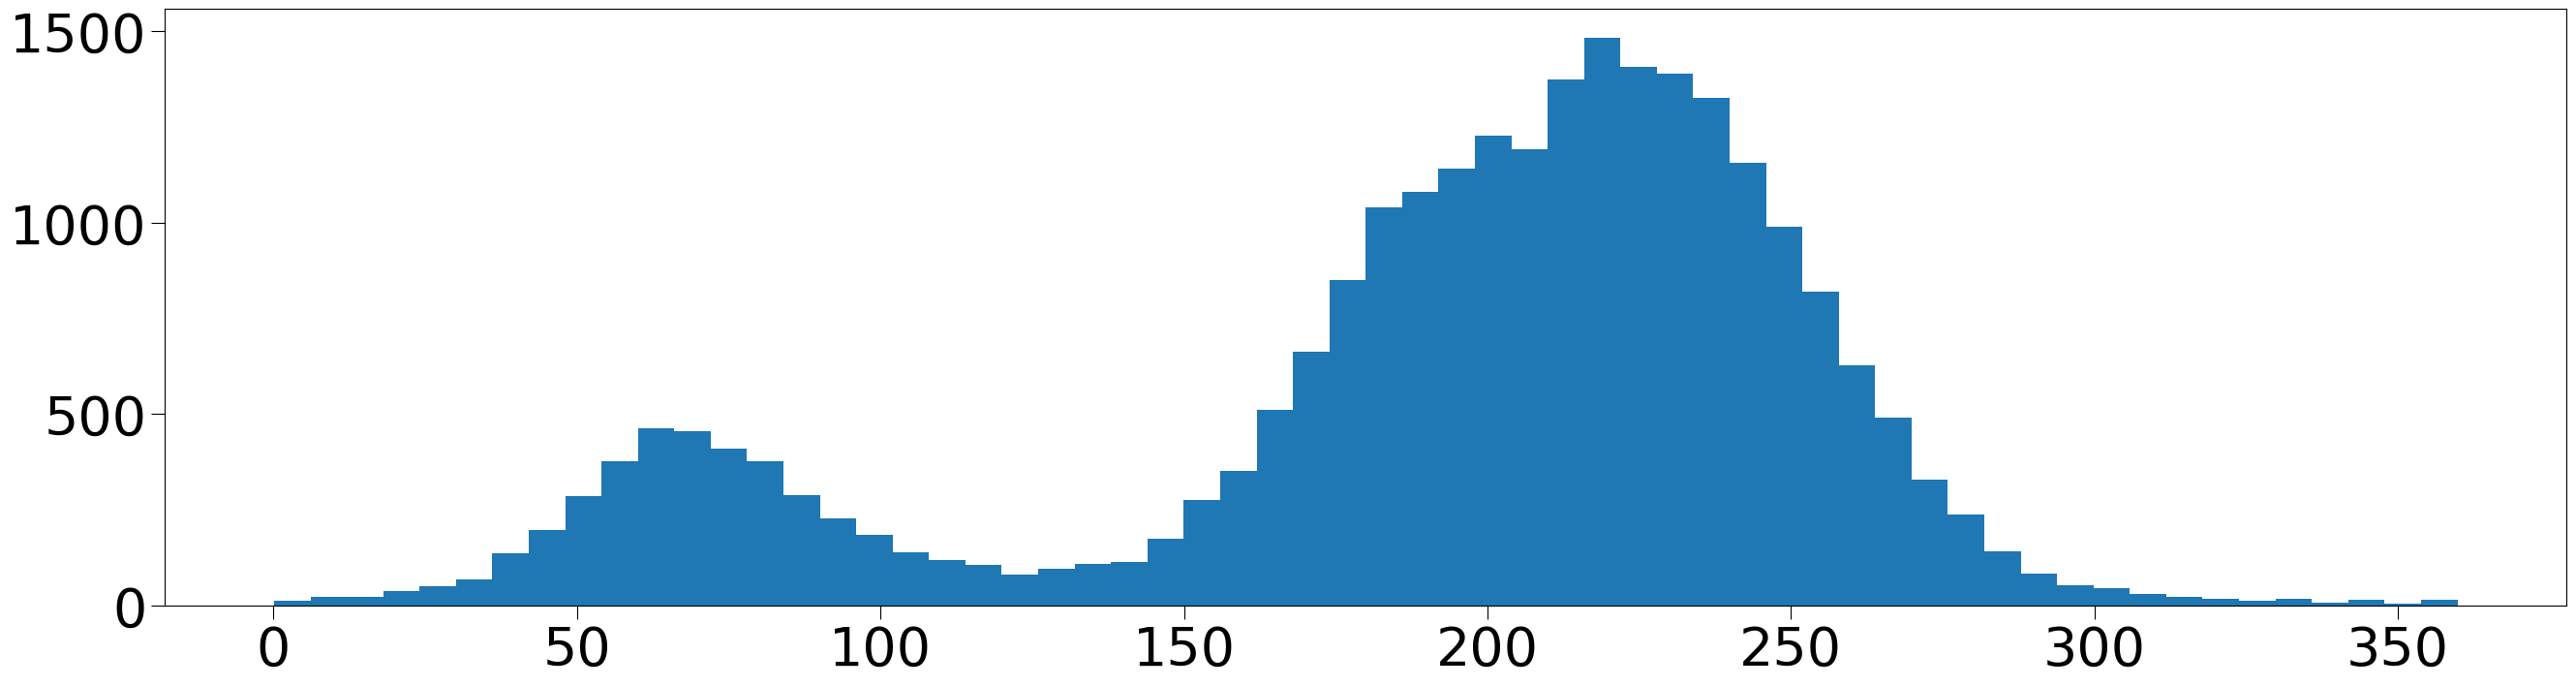

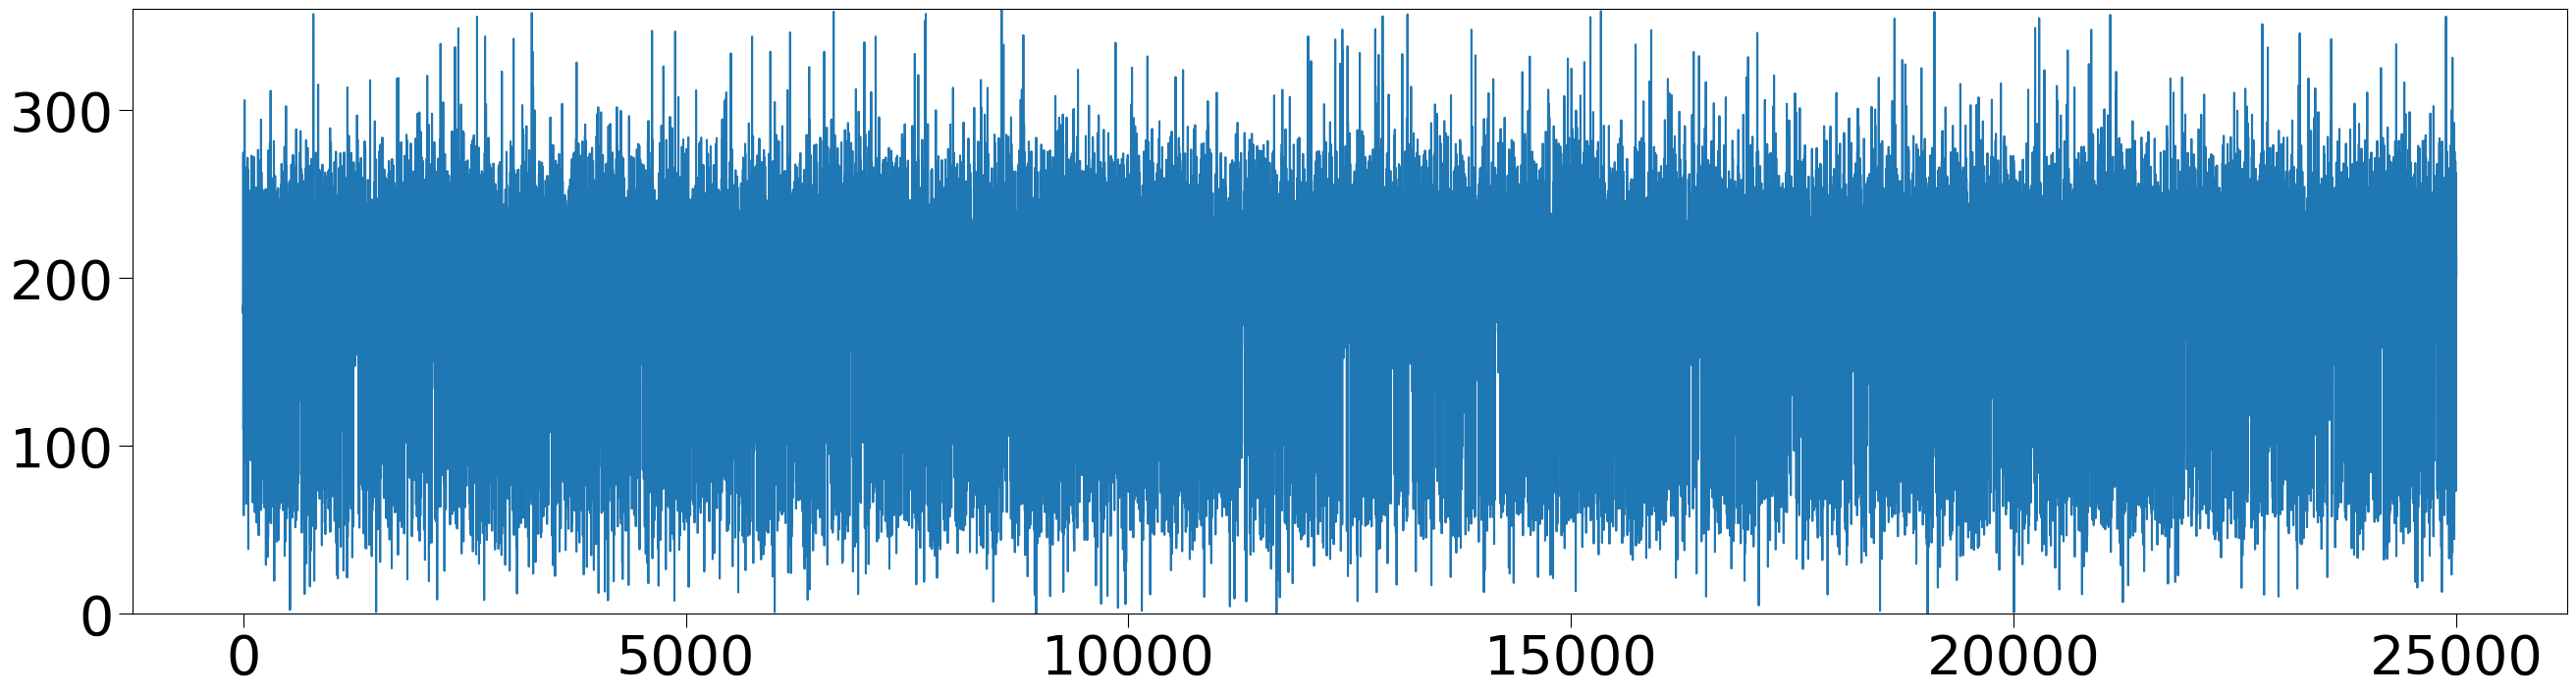

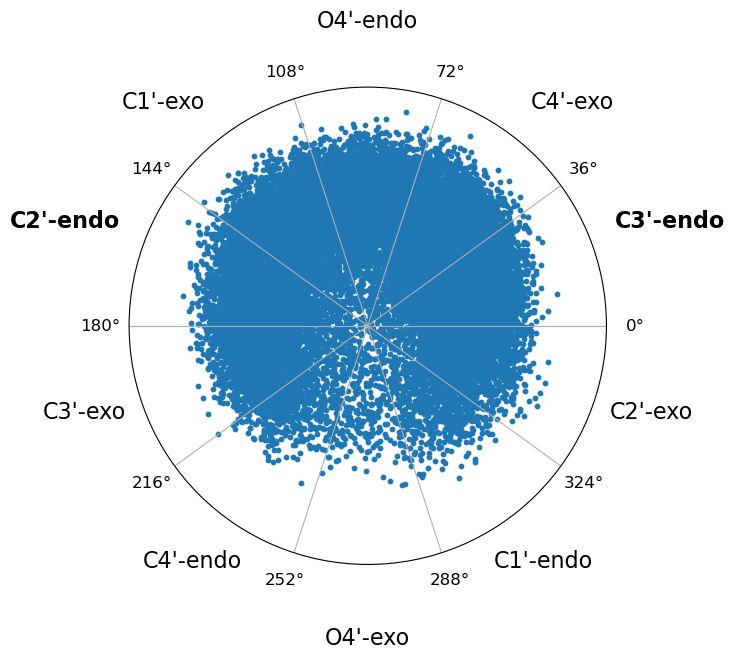

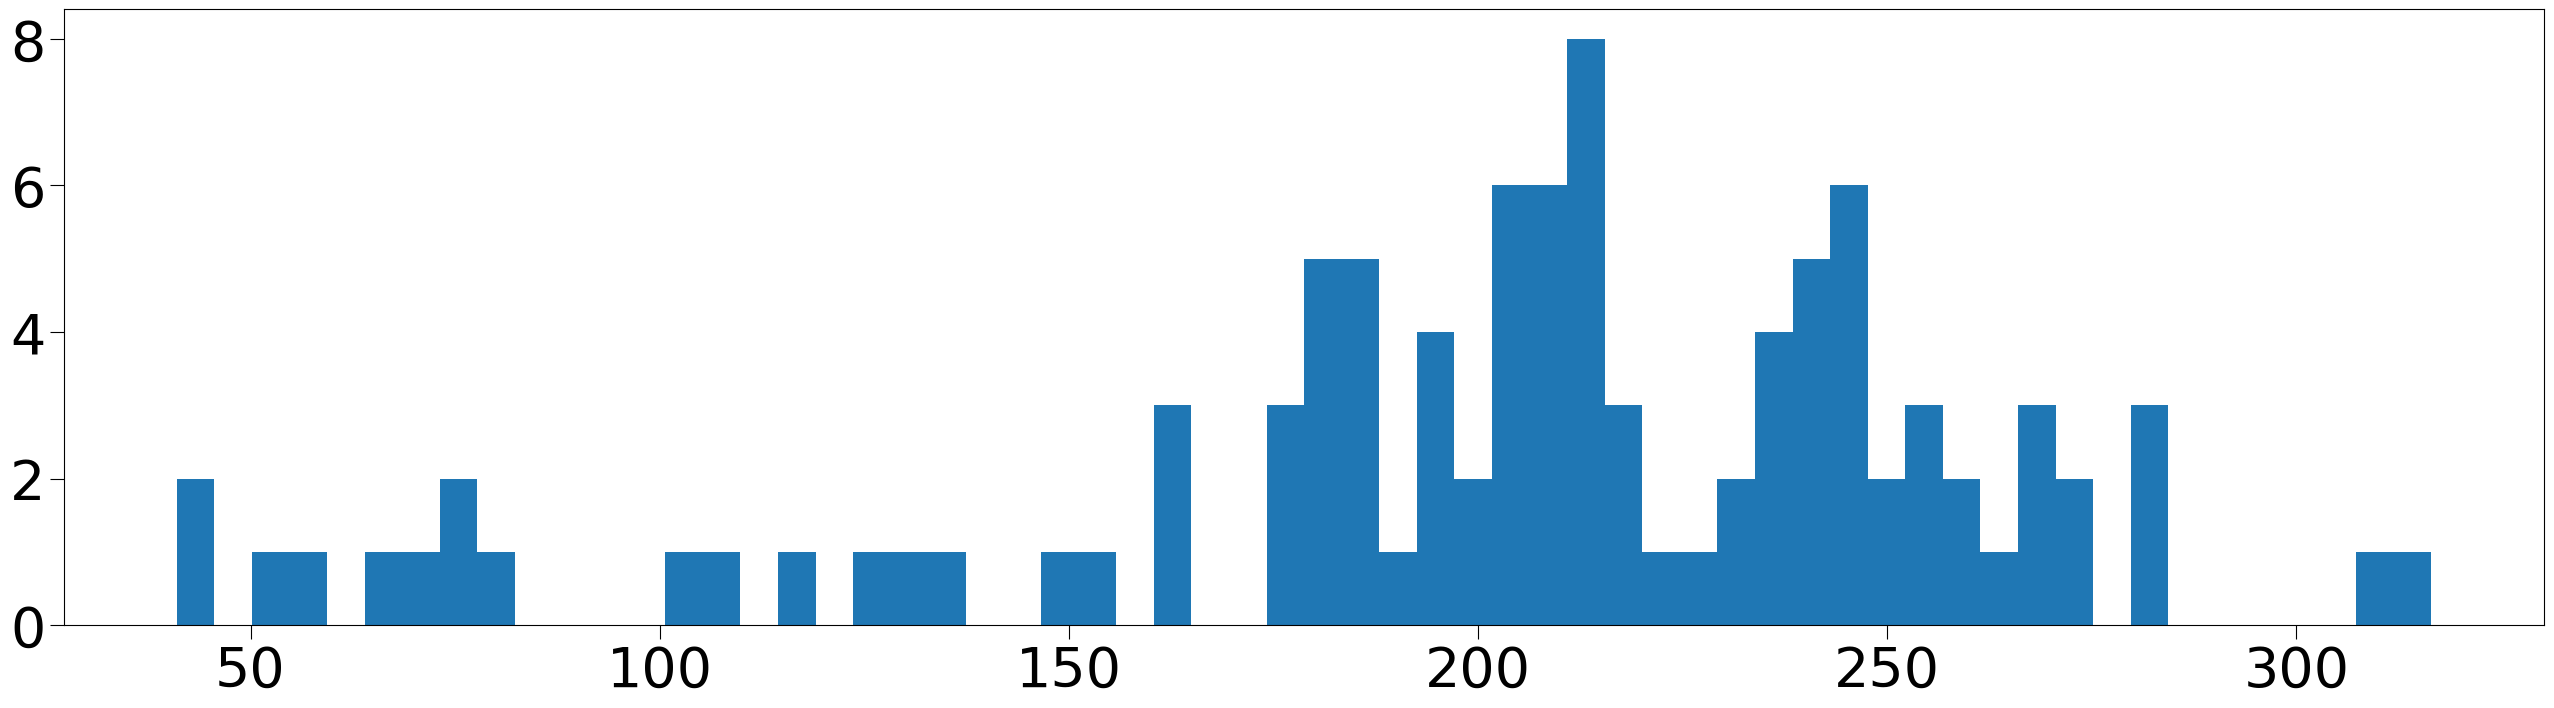

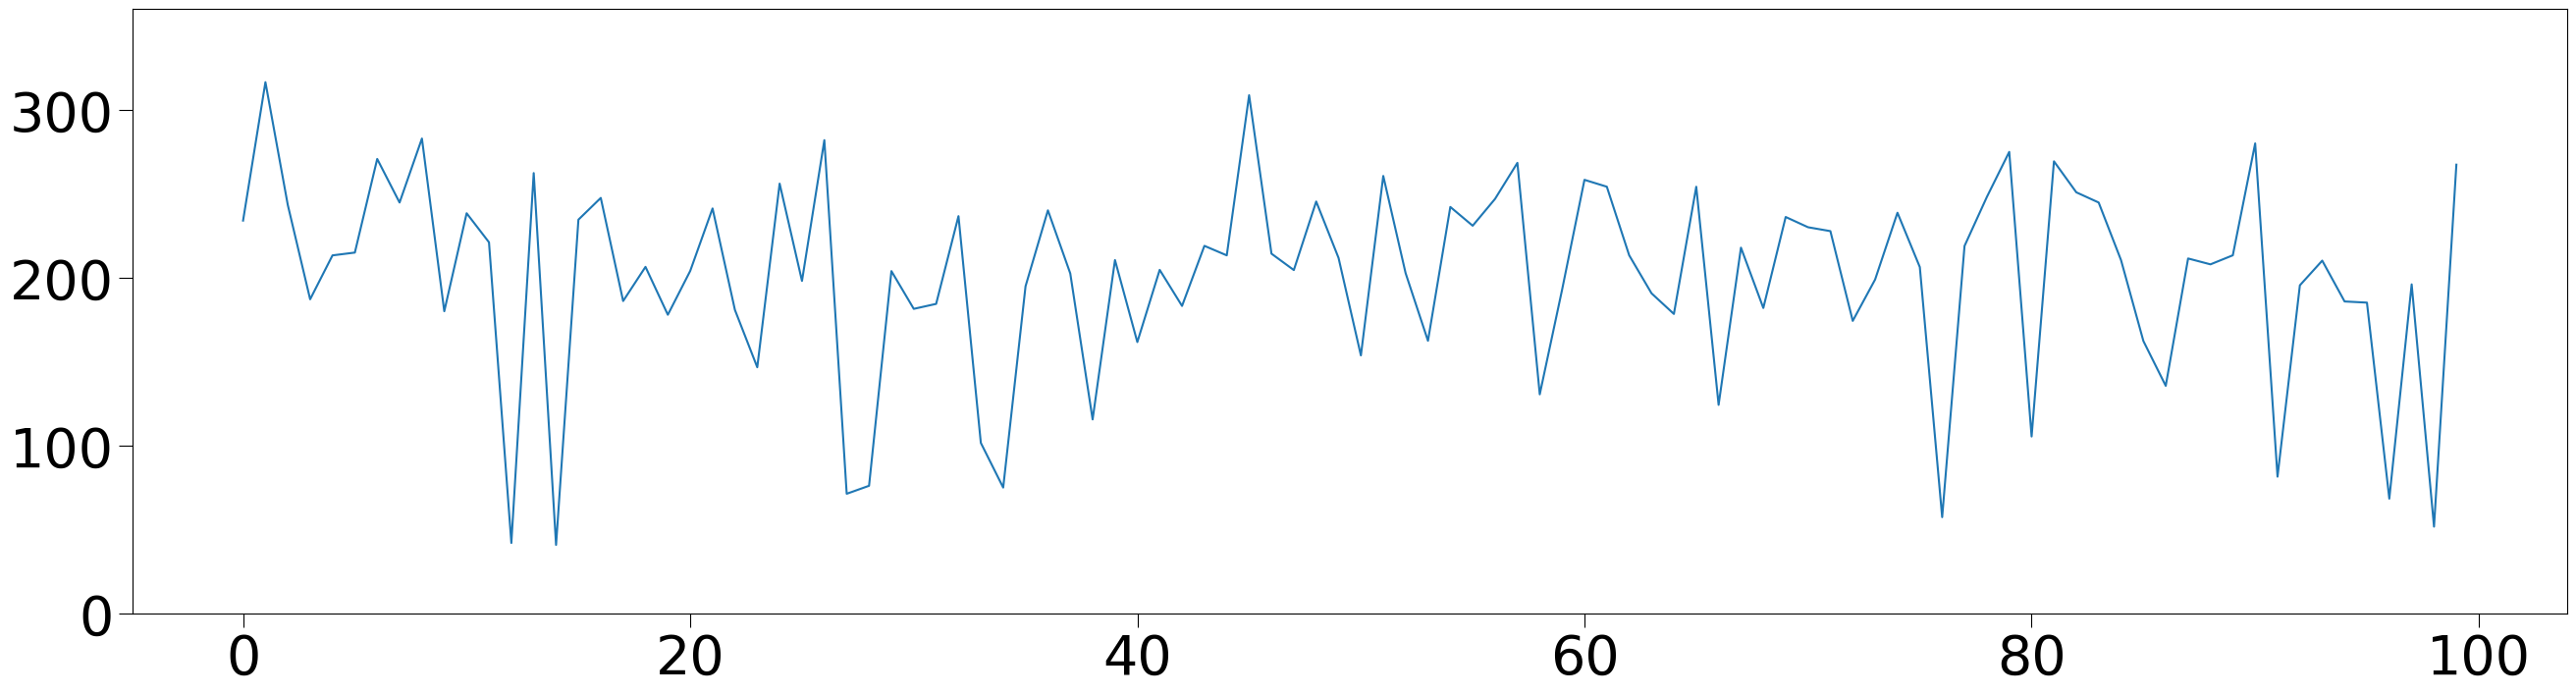

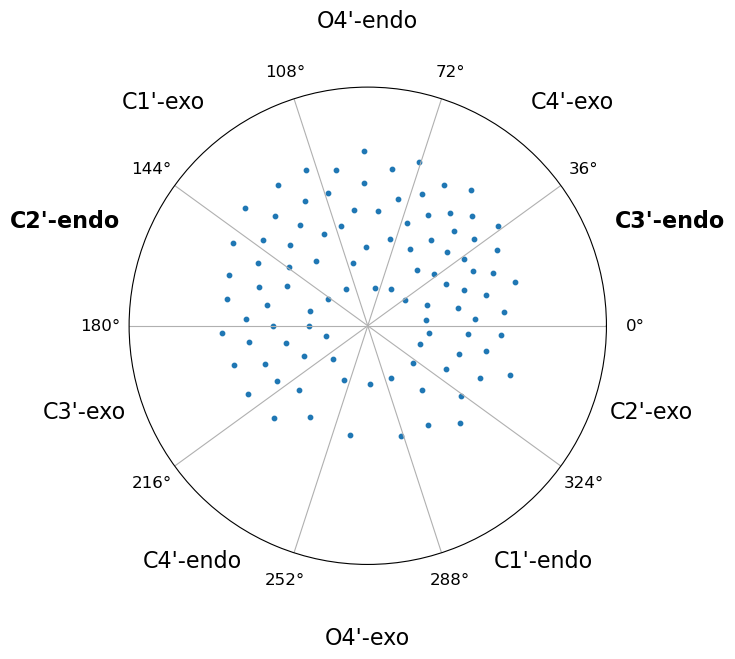

In [46]:
files = glob.glob("../md/g*/traj.nc")
run(files, n_clusters)

#### uridine

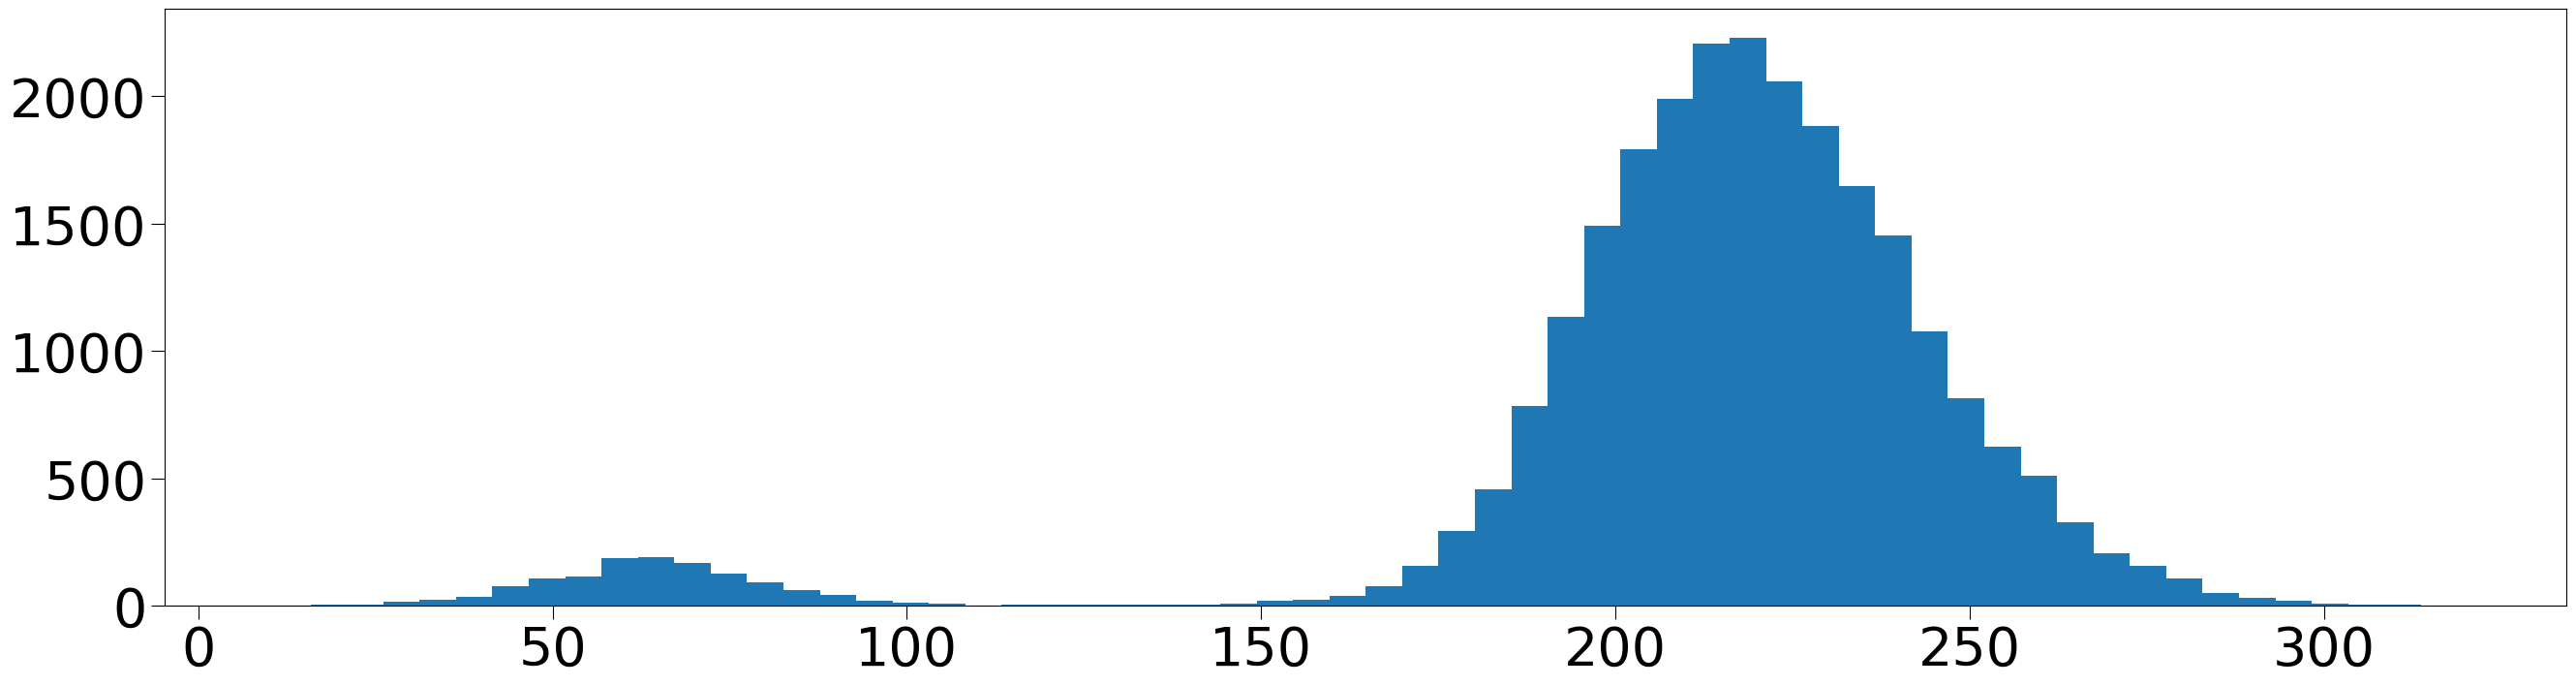

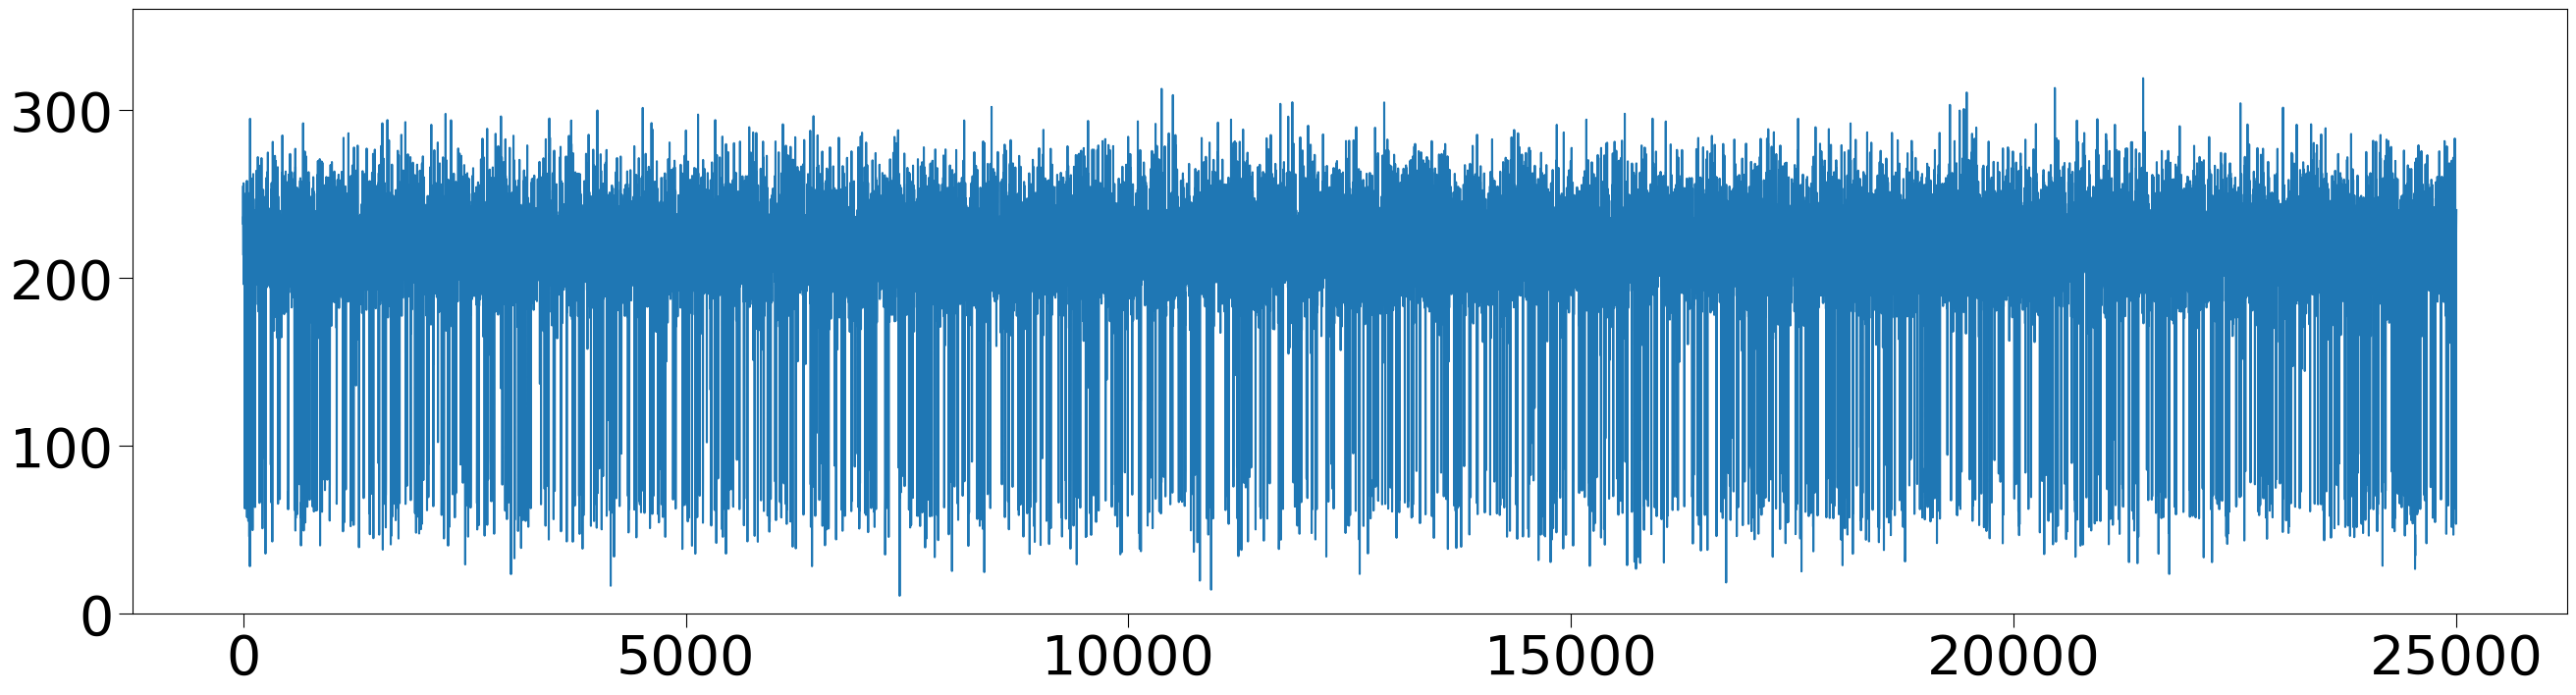

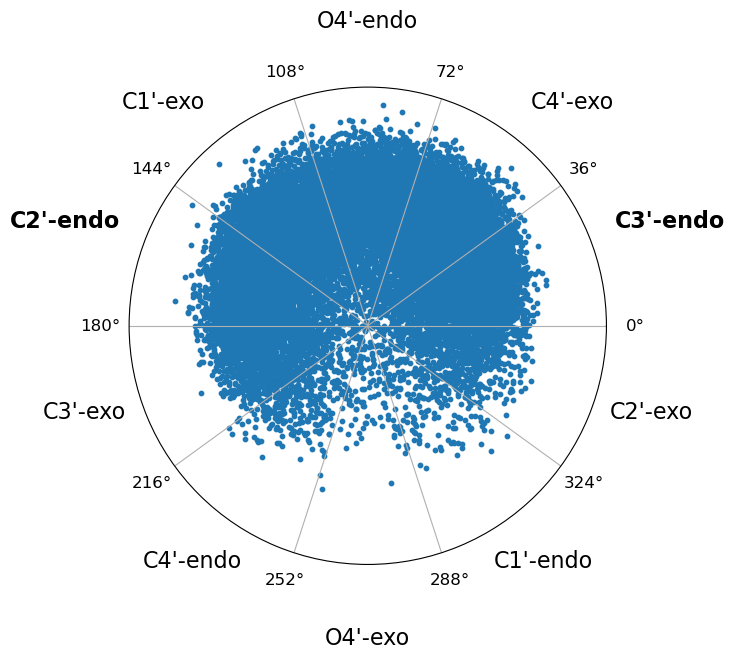

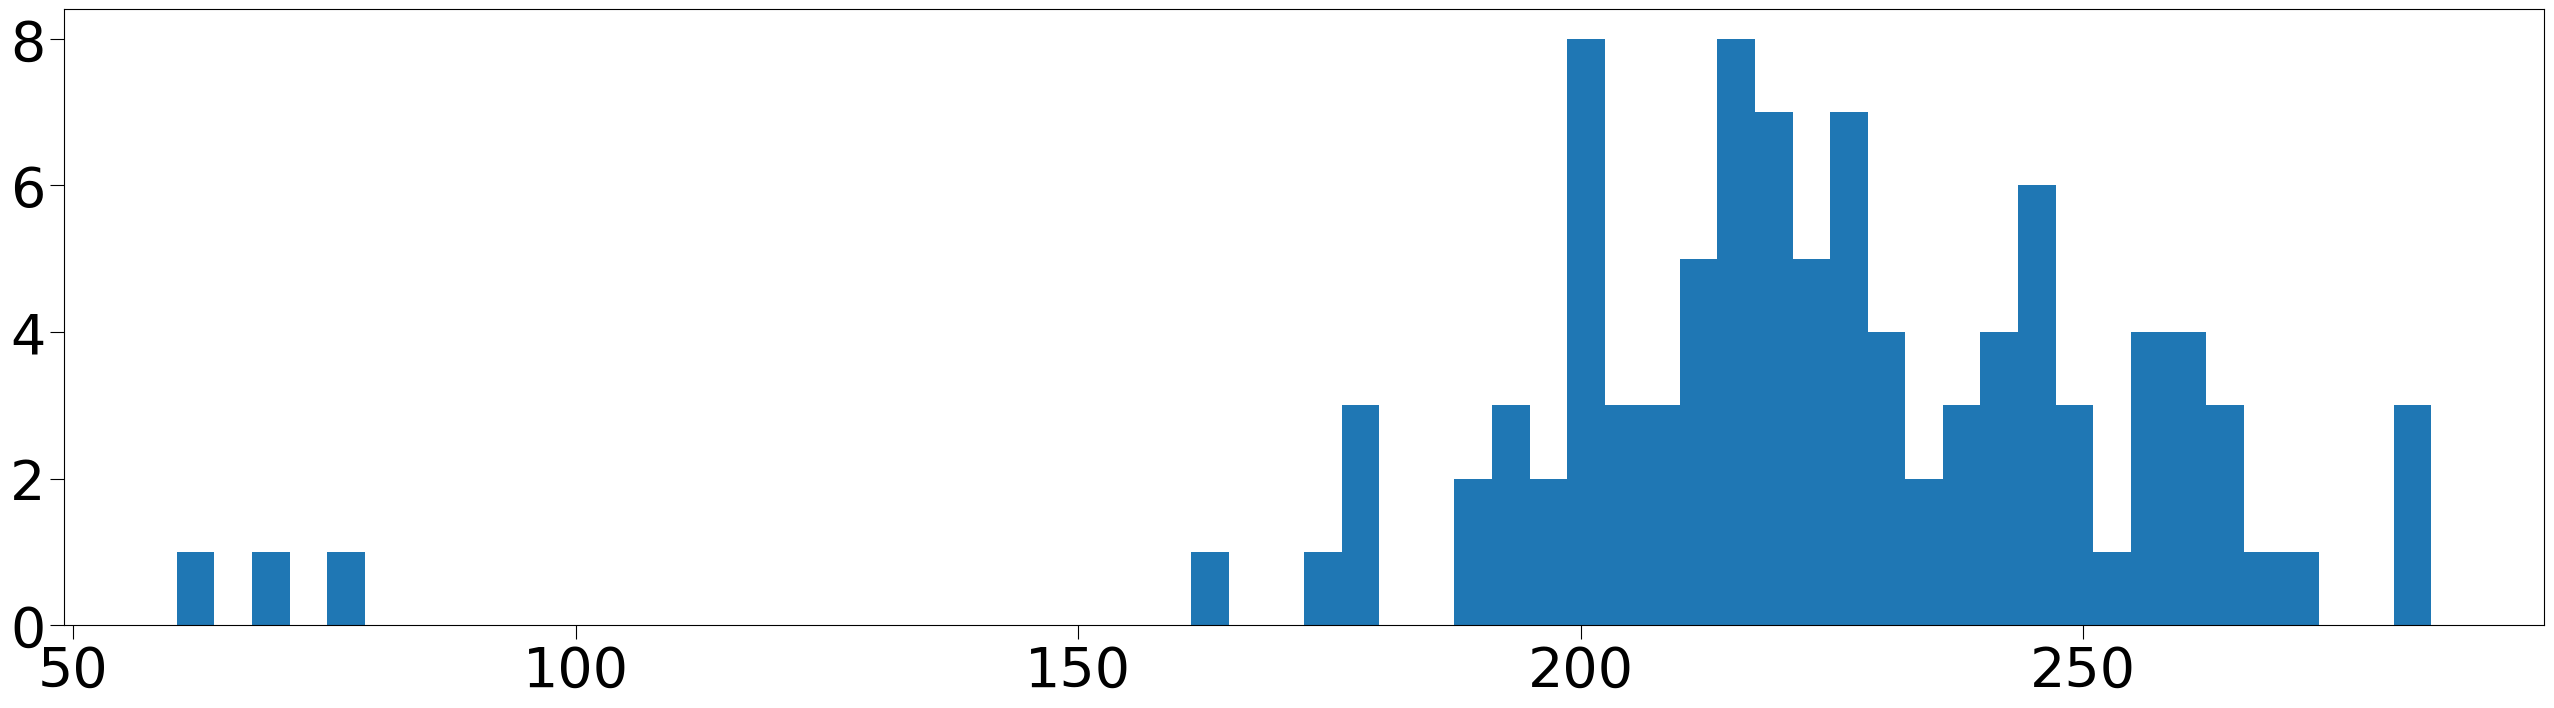

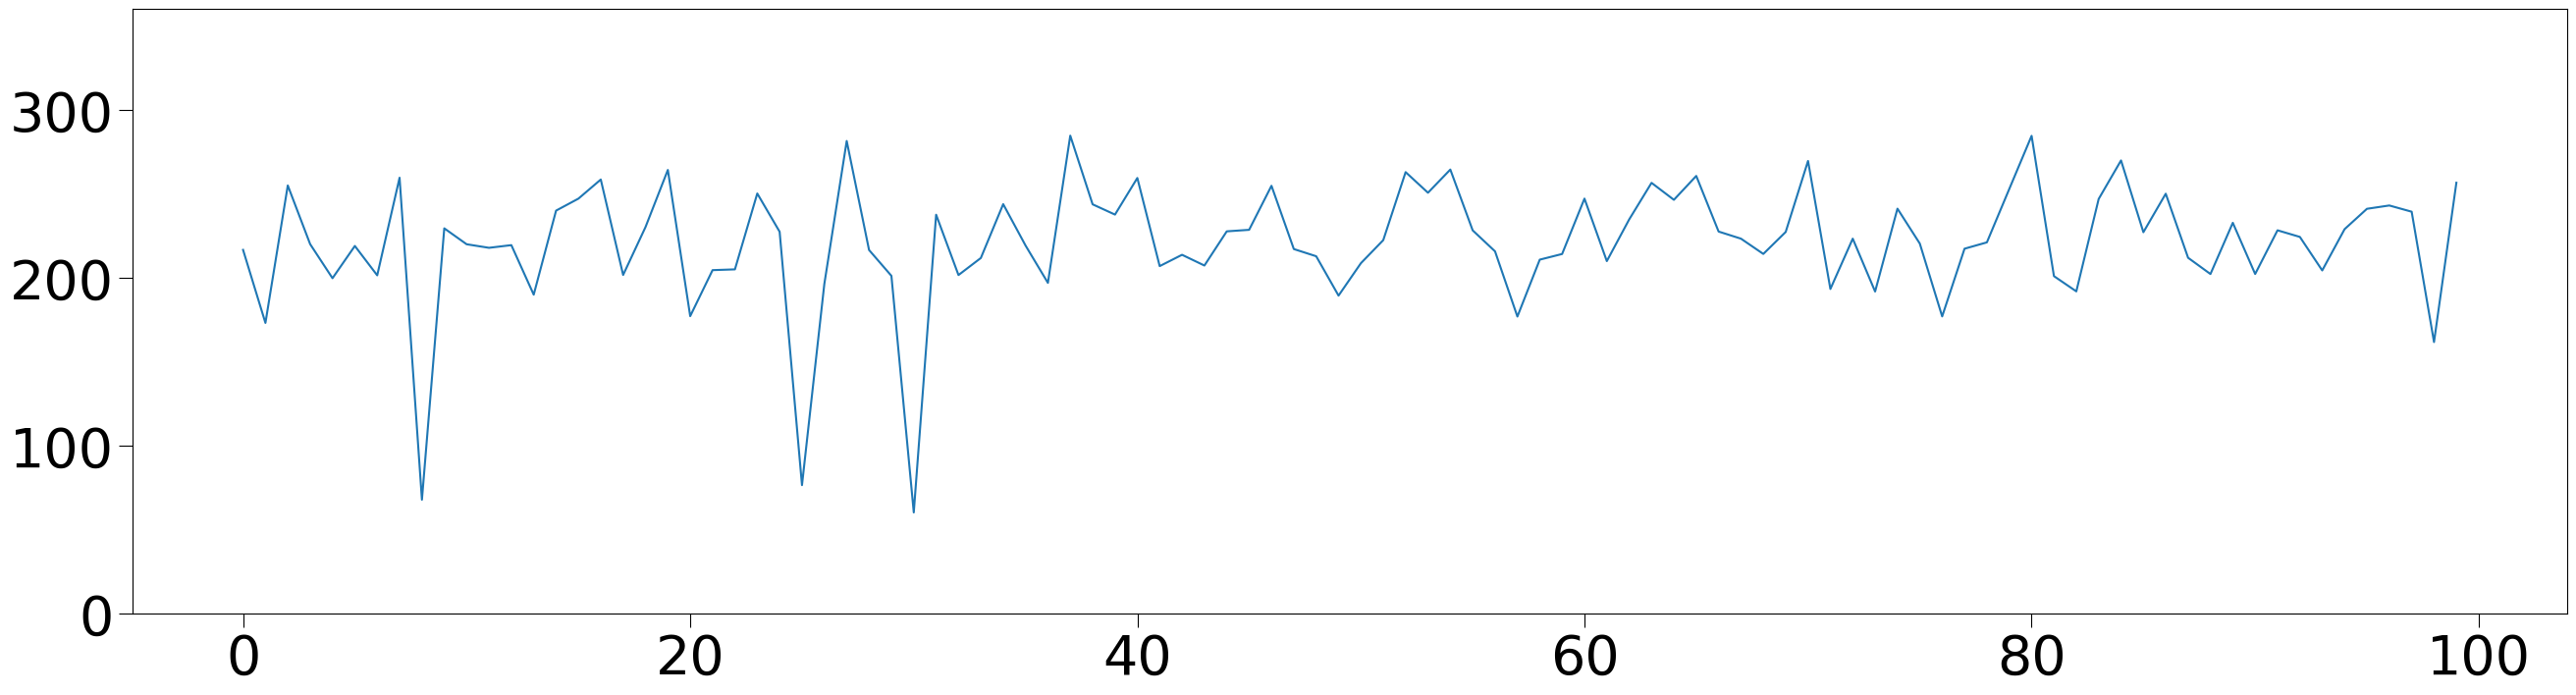

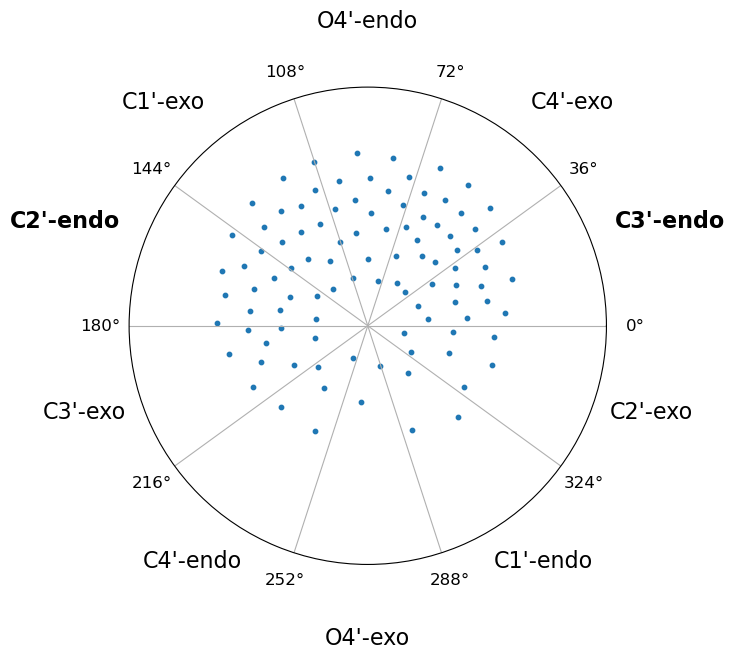

In [47]:
files = glob.glob("../md/u*/traj.nc")
run(files, n_clusters)

## 2. Torsion scan

Perform torsion scan using RDKit against chi dihedral angle. Initial structures taken from clustered sugar pucker structures sampled from implicit solvent MD.
 
https://future-chem.com/rdkit-constrained-conformer/  
https://greglandrum.github.io/rdkit-blog/posts/2023-02-10-more-on-constrained-embedding.html

In [49]:
from openmm import unit
from openff.toolkit.topology import Molecule, Topology
from rdkit import Chem
from rdkit.Chem import Draw, AllChem
from rdkit.Chem import rdForceFieldHelpers
from rdkit.Chem import rdMolTransforms
from rdkit.Chem.Draw import IPythonConsole
IPythonConsole.drawOptions.addAtomIndices = True
IPythonConsole.molSize = 300,300

In [211]:
def torsion_scan(rdmols, chi_atoms, restraint_atoms, output_suffix):
    energies = []
    with Chem.SDWriter(f'torsion_scan_{output_suffix}.sdf') as w:
        for i, rdmol in enumerate(rdmols):
            #print("entry: ", i)
            for dihedral_degree in range(0, 360, 15):
                conf = rdmol.GetConformer()
                rdMolTransforms.SetDihedralDeg(conf, chi_atoms[0], chi_atoms[1], chi_atoms[2], chi_atoms[3], dihedral_degree)
                angle = rdMolTransforms.GetDihedralDeg(conf, chi_atoms[0], chi_atoms[1], chi_atoms[2], chi_atoms[3])

                # initialize ff
                #prop = AllChem.MMFFGetMoleculeProperties(rdmol)
                #ff = AllChem.MMFFGetMoleculeForceField(rdmol, prop)
                prop = rdForceFieldHelpers.MMFFGetMoleculeProperties(rdmol)
                ff = rdForceFieldHelpers.MMFFGetMoleculeForceField(rdmol, prop)
                energy1 = ff.CalcEnergy()

                # apply position restraints to sugar moiety and minimize
                for atom_idx in restraint_atoms:
                    ff.MMFFAddPositionConstraint(atom_idx, 0.01, 1.0e10)
                ff.Minimize(maxIts=5)
                energy2 = ff.CalcEnergy()
                energies.append(energy2)
                #print(f"{angle} degree, {energy1} kcal/mol, {energy2} kcal/mol")

                rdmol.SetProp('_Name', f'{name}{i}')
                rdmol.SetProp('relative_energy', str(energy2))
                
                # export sdf
                w.write(rdmol)

    return energies

In [212]:
def confs_to_mols(_rdmols, chi_atoms):    
    # set each conformer as seperate molecules
    rdmols = []
    for conf in _rdmols.GetConformers():
        _rdmol = Chem.Mol(_rdmols)
        _rdmol.RemoveAllConformers()
        _rdmol.AddConformer(conf)
        rdmols.append(_rdmol)
        
    # check initial chi angle 
    for rdmol in rdmols:
        assert rdmol.GetNumConformers() == 1
        #conf = rdmol.GetConformer()
        #print(rdMolTransforms.GetDihedralDeg(conf, chi_atoms[0], chi_atoms[1], chi_atoms[2], chi_atoms[3]))
        
    return rdmols

In [213]:
def offmol_to_rdmol(name):
    # initialize
    traj = mdtraj.load(f"traj_cls_{name}.nc", top=f"../md/crd/{name}.pdb")
    unique_molecules = Molecule.from_file(f"../md/crd/{name}.sdf")
    topology = Topology.from_openmm(traj[0].topology.to_openmm(), unique_molecules=[unique_molecules])
    mols = Molecule.from_topology(topology)

    # add conformers
    for i in range(len(traj)):
        xyz = np.array(traj.openmm_positions(i)._value)
        mols.add_conformer(unit.Quantity(xyz, traj.openmm_positions(i).unit))

    # convert openff molecule to rdkit molecule
    _rdmols = mols.to_rdkit()
    
    return _rdmols

#### define sugar

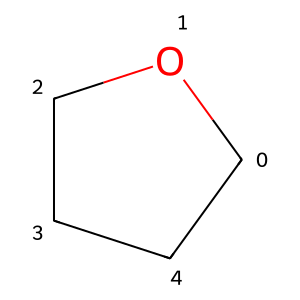

In [214]:
sugar = Chem.MolFromSmiles('C1OCCC1')
sugar

#### adenosine

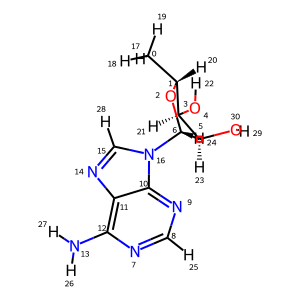

In [215]:
name = "a"

# load clustered trajectories as openff molecule and convert them into rdkit molecules
_rdmols = offmol_to_rdmol(name)
_rdmols

In [216]:
chi_atoms = [2, 6, 16, 10]
restraint_atoms = list(rdmols[0].GetSubstructMatch(sugar))
print(restraint_atoms)

# convert rdkit conformers into seperate rdmol 
rdmols = confs_to_mols(_rdmols, chi_atoms)

# torsion scan with sugar atom positional restraint
energies = torsion_scan(rdmols[1:], chi_atoms, restraint_atoms, name)  # exclude first entry (sdf structure)

[1, 2, 6, 5, 3]


In [220]:
e = np.array(energies)  # unit: kcal/mol
e = e - e.min()
print('total # of conformers: ', len(e))
print('maximum relative energy: ', e.max())
print('# conformers with >100 kcal/mol: ', len(np.where(e > 100)[0]))

total # of conformers:  2400
maximum relative energy:  337.10613048150424
# conformers with >100 kcal/mol:  20


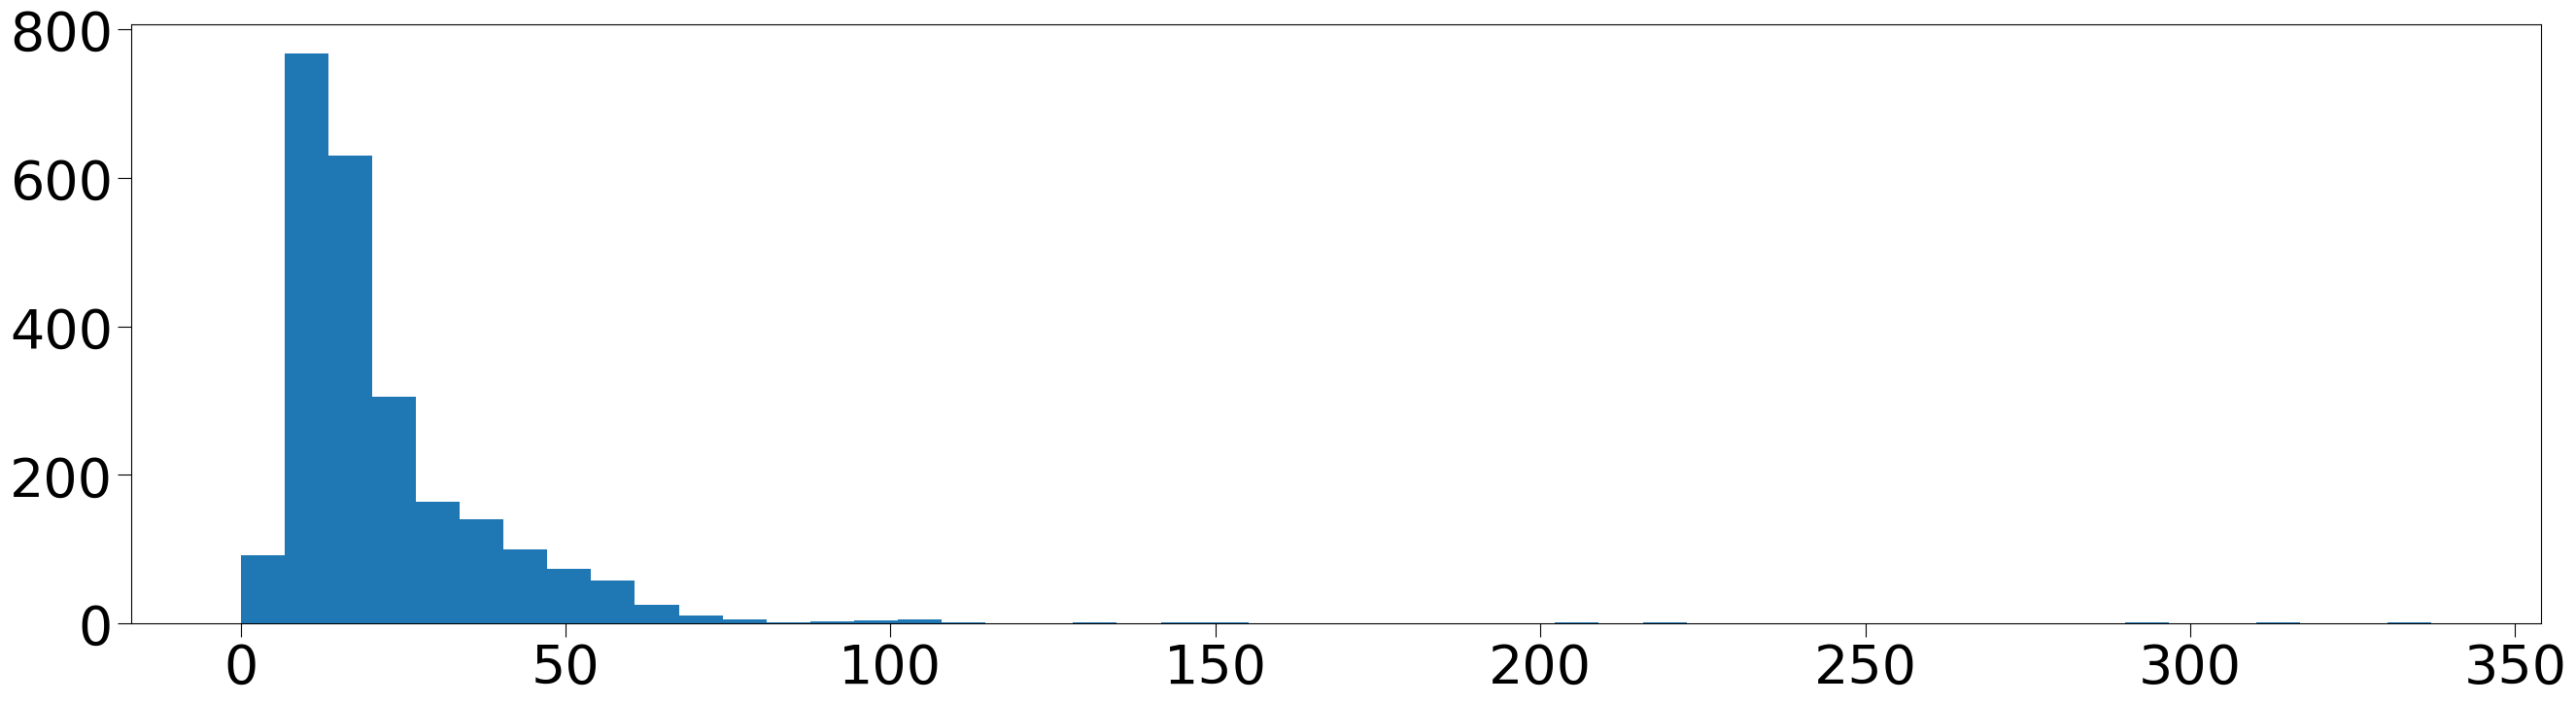

In [221]:
# check energy distribution
plt.hist(e, bins=50)
plt.show()

#### cytidine

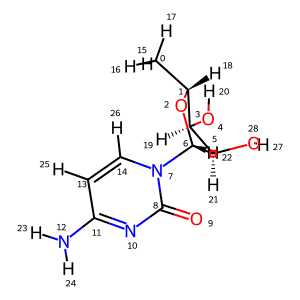

In [186]:
name = "c"
_rdmols = offmol_to_rdmol(name)
_rdmols

In [187]:
chi_atoms = [2, 6, 7, 8]
restraint_atoms = list(rdmols[0].GetSubstructMatch(sugar))
print(restraint_atoms)

rdmols = confs_to_mols(_rdmols, chi_atoms)
energies = torsion_scan(rdmols[1:], chi_atoms, restraint_atoms, name)

[1, 2, 6, 5, 3]


In [188]:
e = np.array(energies)  # unit: kcal/mol
e = e - e.min()
print('total # of conformers: ', len(e))
print('maximum relative energy: ', e.max())
print('# conformers with >100 kcal/mol: ', len(np.where(e > 100)[0]))

total # of conformers:  2400
maximum relative energy:  139.81914315866254
# conformers with >100 kcal/mol:  2


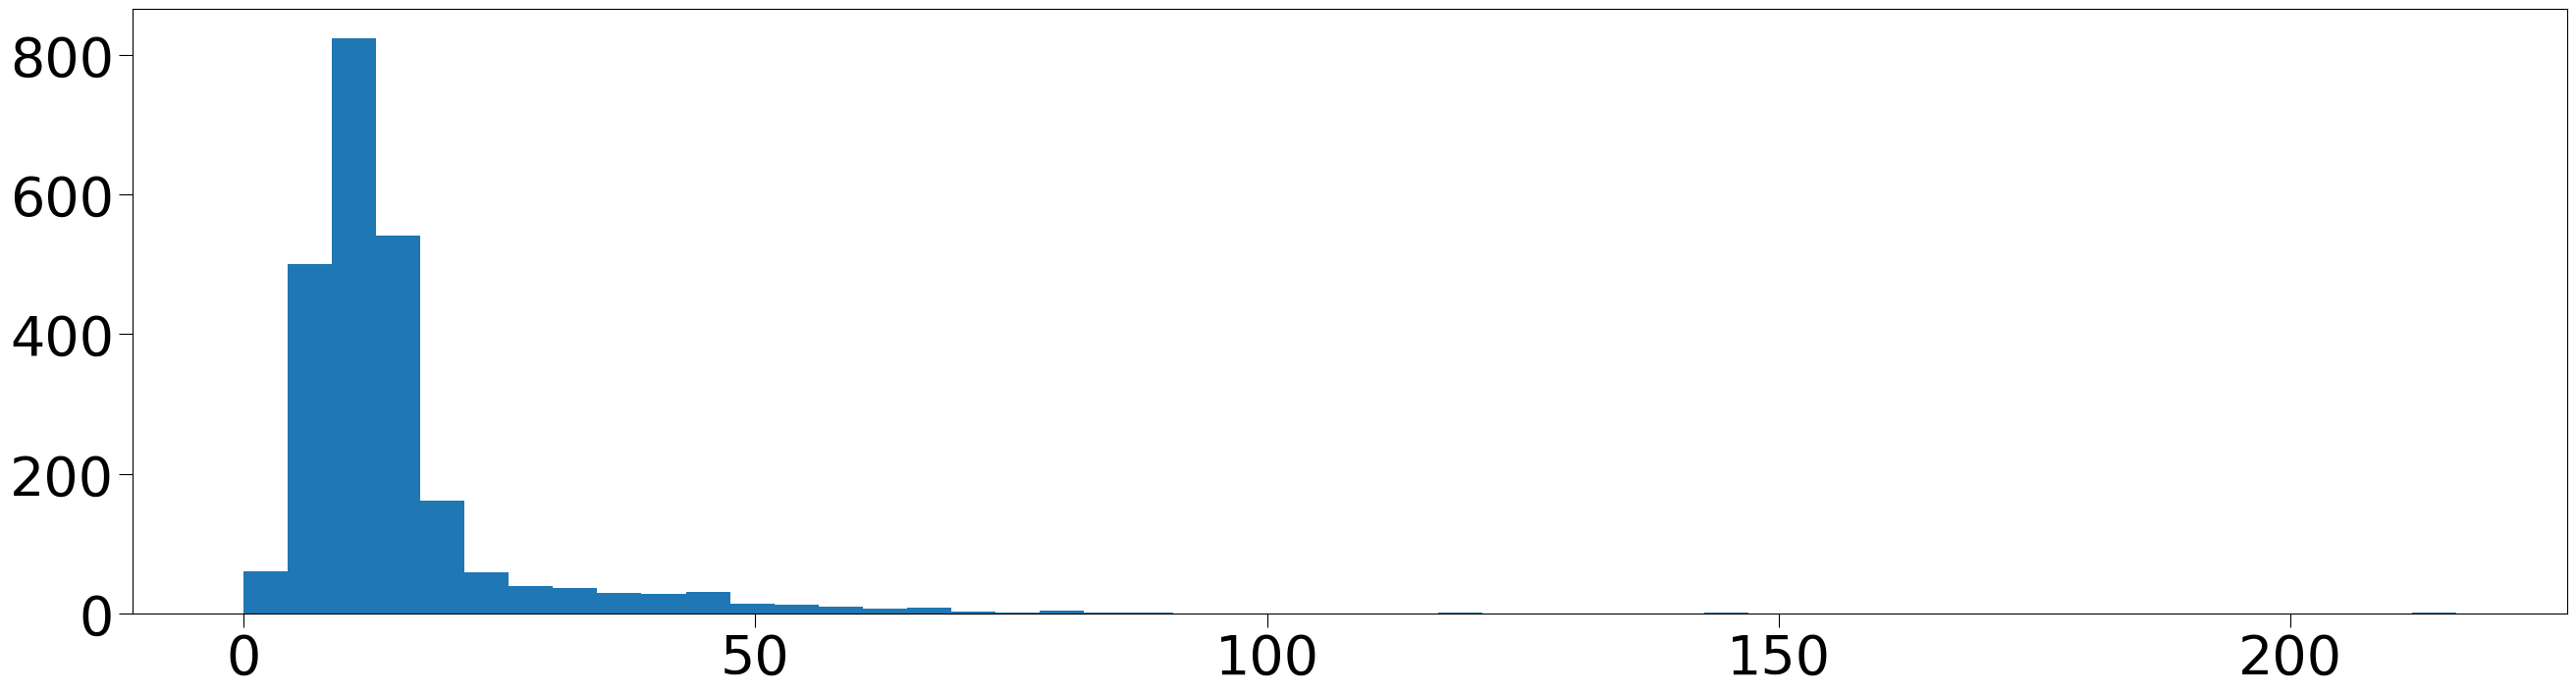

In [193]:
# check energy distribution
plt.hist(e, bins=50)
plt.show()

#### guanosine

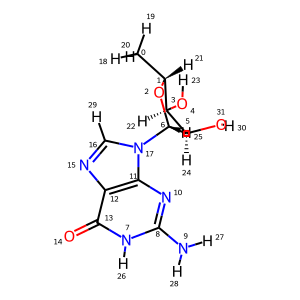

In [190]:
name = "g"
_rdmols = offmol_to_rdmol(name)
_rdmols

In [191]:
chi_atoms = [2, 6, 17, 11]
restraint_atoms = list(rdmols[0].GetSubstructMatch(sugar))
print(restraint_atoms)

rdmols = confs_to_mols(_rdmols, chi_atoms)
energies = torsion_scan(rdmols[1:], chi_atoms, restraint_atoms, name)

[1, 2, 6, 5, 3]


In [192]:
e = np.array(energies)  # unit: kcal/mol
e = e - e.min()
print('total # of conformers: ', len(e))
print('maximum relative energy: ', e.max())
print('# conformers with >100 kcal/mol: ', len(np.where(e > 100)[0]))

total # of conformers:  2400
maximum relative energy:  216.17945312234218
# conformers with >100 kcal/mol:  17


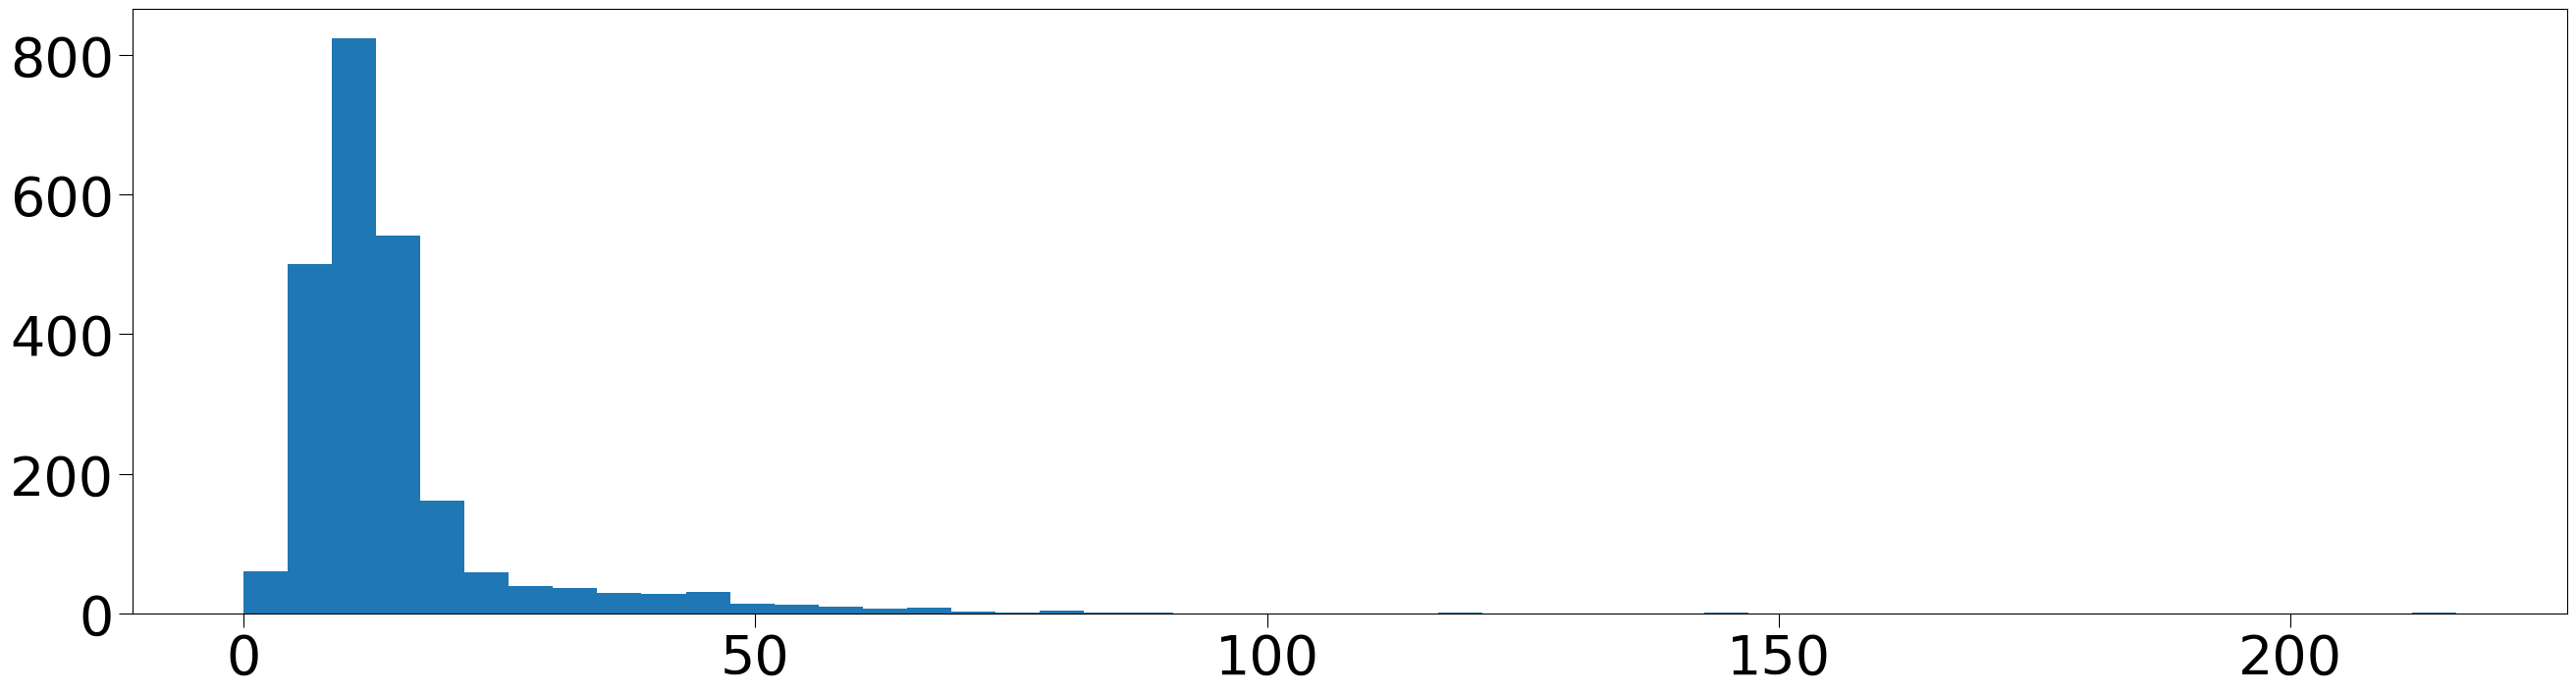

In [194]:
# check energy distribution
plt.hist(e, bins=50)
plt.show()

#### uridine

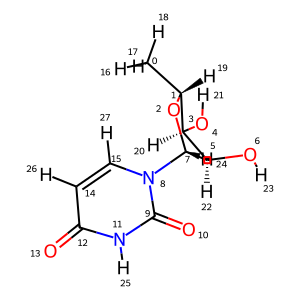

In [195]:
name = "u"
_rdmols = offmol_to_rdmol(name)
_rdmols

In [196]:
chi_atoms = [2, 7, 8, 9]
restraint_atoms = list(rdmols[0].GetSubstructMatch(sugar))
print(restraint_atoms)

rdmols = confs_to_mols(_rdmols, chi_atoms)
energies = torsion_scan(rdmols[1:], chi_atoms, restraint_atoms, name)

[1, 2, 6, 5, 3]


In [197]:
e = np.array(energies)  # unit: kcal/mol
e = e - e.min()
print('total # of conformers: ', len(e))
print('maximum relative energy: ', e.max())
print('# conformers with >100 kcal/mol: ', len(np.where(e > 100)[0]))

total # of conformers:  2400
maximum relative energy:  119.23033383415812
# conformers with >100 kcal/mol:  5


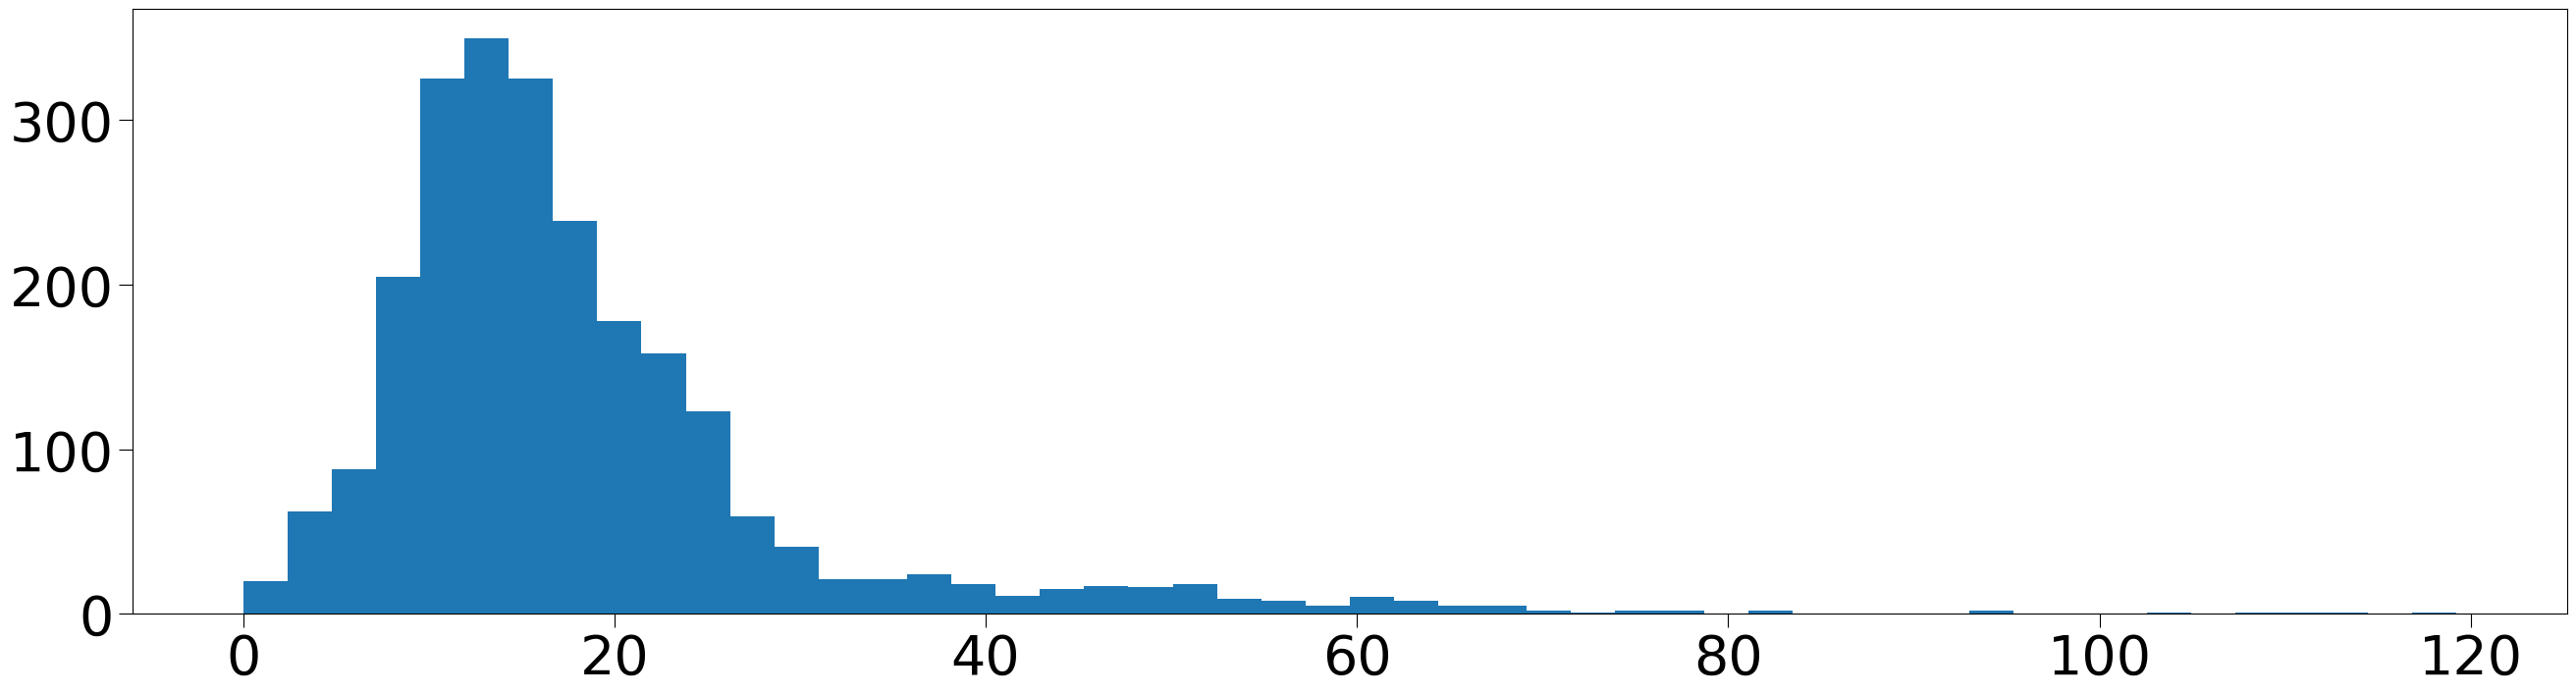

In [198]:
# check energy distribution
plt.hist(e, bins=50)
plt.show()